## Introduction

Stan solution to [nested_model_example.ipynb](nested_model_example.ipynb).


In [1]:
# set up Python
import json
import logging
import numpy as np
import pandas as pd
import plotnine
from plotnine import *

from nested_model_fns import (
    define_Stan_model_with_forecast_period,
    solve_forecast_by_Stan,
    plot_forecast,
    extract_sframe_result,
    plot_model_quality,
    plot_model_quality_by_prefix,
    plot_recent_state_distribution,
)

# quiet down Stan
logger = logging.getLogger("cmdstanpy")
logger.addHandler(logging.NullHandler())

# set plot size
plotnine.options.figure_size = (16, 8)

In [2]:
with open("generating_params.json", "r") as file:
    generating_params = json.load(file)
modeling_lags = generating_params["generating_lags"]
b_z = generating_params["b_z"]
b_x = generating_params["b_x"]

generating_params

{'b_auto_0': 1.2804125781056719,
 'b_auto': [1.9753766811902755, -1],
 'b_z': [14.2],
 'b_x': [16.1],
 'generating_lags': [1, 2],
 'modeling_lags': [1, 2]}

In [3]:
d_train = pd.read_csv("d_train.csv")
d_test = pd.read_csv("d_test.csv")

## Solving again with the Bayesian "big hammer"


We now try a Bayesian model with the correct generative structure, using the [Stan](https://mc-stan.org/users/interfaces/cmdstan) software package.


In [4]:
# define a Stan model for both transient external regressors and future predictions
stan_model_with_forecast_i, stan_model_with_forecast_src_i = (
    define_Stan_model_with_forecast_period(
        application_lags=modeling_lags,
        n_transient_external_regressors=len(b_x),
        n_durable_external_regressors=len(b_z),
    )
)

In [5]:
# show the model specification
print(stan_model_with_forecast_src_i)


data {
  int<lower=1> N_y_observed;                  // number of observed y outcomes
  int<lower=1> N_y_future;                    // number of future outcomes to infer
  vector<lower=0>[N_y_observed] y_observed;            // observed outcomes
  vector[N_y_observed + N_y_future] x_imp_1;  // observed transient external regressor
  vector[N_y_observed + N_y_future] x_dur_1;  // observed durable external regressor
}
parameters {
  real b_auto_0;                      // auto-regress intercept
  vector[2] b_auto;                           // auto-regress coefficients
  vector[1] b_x_imp;                          // transient external regressor coefficients
  vector[1] b_x_dur;                          // durable external regressor coefficients
  vector<lower=0>[N_y_future] y_future;                // to be inferred future state
  vector<lower=0>[N_y_observed + N_y_future] y_auto;   // unobserved auto-regressive state
  real<lower=0> b_var_y_auto;                 // presumed y_auto (dura

`y` and `y_auto` are supposed to be non-negative (a constraint we have chosen to *not* enforce, as it degraded results, probably by damaging sampling paths).

Please keep in mind a distributional statement such as <code>y ~ normal(f(y_auto, x), &sigma;)</code> is actually modeling the residual <code>(y - f(y_auto, x))</code> as being distributed <code>normal(0, &sigma;)</code>. So the above model-block statements are distributional assumptions about *residuals*, as the intended mean is an input to these statements. Thus we are specifying a normal distribution for residuals, not a normal distribution for expected values or predictions. I feel the normal approximation for `y`'s residual is not that bad. A similar statement can be made for `y_auto`'s residuals.

All in all: specifying systems to Stan is a compromise in respecting problem structure, and preserving the ability to effectively sample. The specification tends to requires some compromise and experimentation. In my opinion, it isn't quite the case that "Bayes' Law names only one legitimate inferential network and we can then use that one!" One is going to have to specify an approximate system. It becomes the user's responsibility to design for a (hopefully) high utility tradeoff between fidelity and realizability.


What Stan generates is: thousands of possible trajectories of parameters, and past and future hidden state.


In [6]:
# sample from Stan model solutions
forecast_soln_i = solve_forecast_by_Stan(
    model=stan_model_with_forecast_i,
    d_train=d_train,
    d_apply=d_test,
    durable_external_regressors=["z_0"],
    transient_external_regressors=["x_0"],
)

forecast_soln_i  # see https://mc-stan.org/docs/cmdstan-guide/stansummary.html

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,b_auto_0,b_auto[0],b_auto[1],...,y[990],y[991],y[992],y[993],y[994],y[995],y[996],y[997],y[998],y[999]
0,2422.06,0.966003,0.012435,9.0,511.0,0.0,-1940.36,1.51898,1.93560,-0.963077,...,66.6320,81.7590,68.0079,68.7424,69.5934,71.0835,86.1782,83.6870,79.9718,57.3583
1,2408.97,0.979260,0.012435,9.0,511.0,0.0,-1917.68,1.48301,1.93370,-0.960648,...,64.3027,81.6178,67.4716,67.7043,66.2853,66.4040,80.7445,77.4683,77.5189,60.5005
2,2406.41,0.985678,0.012435,9.0,511.0,0.0,-1921.21,1.56821,1.93958,-0.967600,...,62.7144,87.5645,79.8141,87.2647,90.0175,94.8252,113.3220,117.3030,122.6950,104.7030
3,2394.28,0.780995,0.012435,9.0,511.0,0.0,-1876.91,1.55317,1.93763,-0.964870,...,67.6983,88.3019,74.4680,75.0257,73.9687,72.9321,84.6862,79.7102,77.6661,58.2702
4,2380.00,0.966760,0.012435,9.0,511.0,0.0,-1874.33,1.53446,1.93014,-0.958076,...,70.2634,89.8686,74.8370,76.3530,78.2148,80.2669,92.9408,88.5373,88.1798,71.0078
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,2364.67,0.829765,0.014792,9.0,511.0,0.0,-1896.77,1.47315,1.94180,-0.968659,...,84.7791,105.1100,93.0849,93.2580,94.0806,94.9891,108.7570,109.5600,106.5080,89.4674
3996,2380.05,0.917991,0.014792,9.0,511.0,0.0,-1845.67,1.61915,1.93131,-0.960186,...,105.1580,126.3660,115.2770,120.7540,123.1020,124.3980,139.1080,140.0210,132.9120,111.0100
3997,2403.73,0.909507,0.014792,9.0,511.0,0.0,-1867.24,1.51113,1.94244,-0.969442,...,108.2820,124.7110,107.6520,105.8600,103.6010,100.3070,114.4380,111.4990,107.3590,88.2563
3998,2385.19,0.770991,0.014792,9.0,511.0,0.0,-1882.53,1.61643,1.93609,-0.964987,...,97.9794,118.4330,105.8290,105.6310,106.2460,103.8980,116.5320,111.4680,107.7050,85.2146


We can look at a summary of the parameter estimates.


In [7]:
# summarize parameter estimates
soln_params_i = forecast_soln_i.loc[
    :, [c for c in forecast_soln_i if c.startswith("b_")]
].median()

soln_params_i

b_auto_0         1.550680
b_auto[0]        1.937430
b_auto[1]       -0.965318
b_x_imp[0]      15.907350
b_x_dur[0]      13.550350
b_var_y_auto     1.109715
b_var_y          1.035610
dtype: float64

In [8]:
# show original generative parameters
generating_params

{'b_auto_0': 1.2804125781056719,
 'b_auto': [1.9753766811902755, -1],
 'b_z': [14.2],
 'b_x': [16.1],
 'generating_lags': [1, 2],
 'modeling_lags': [1, 2]}

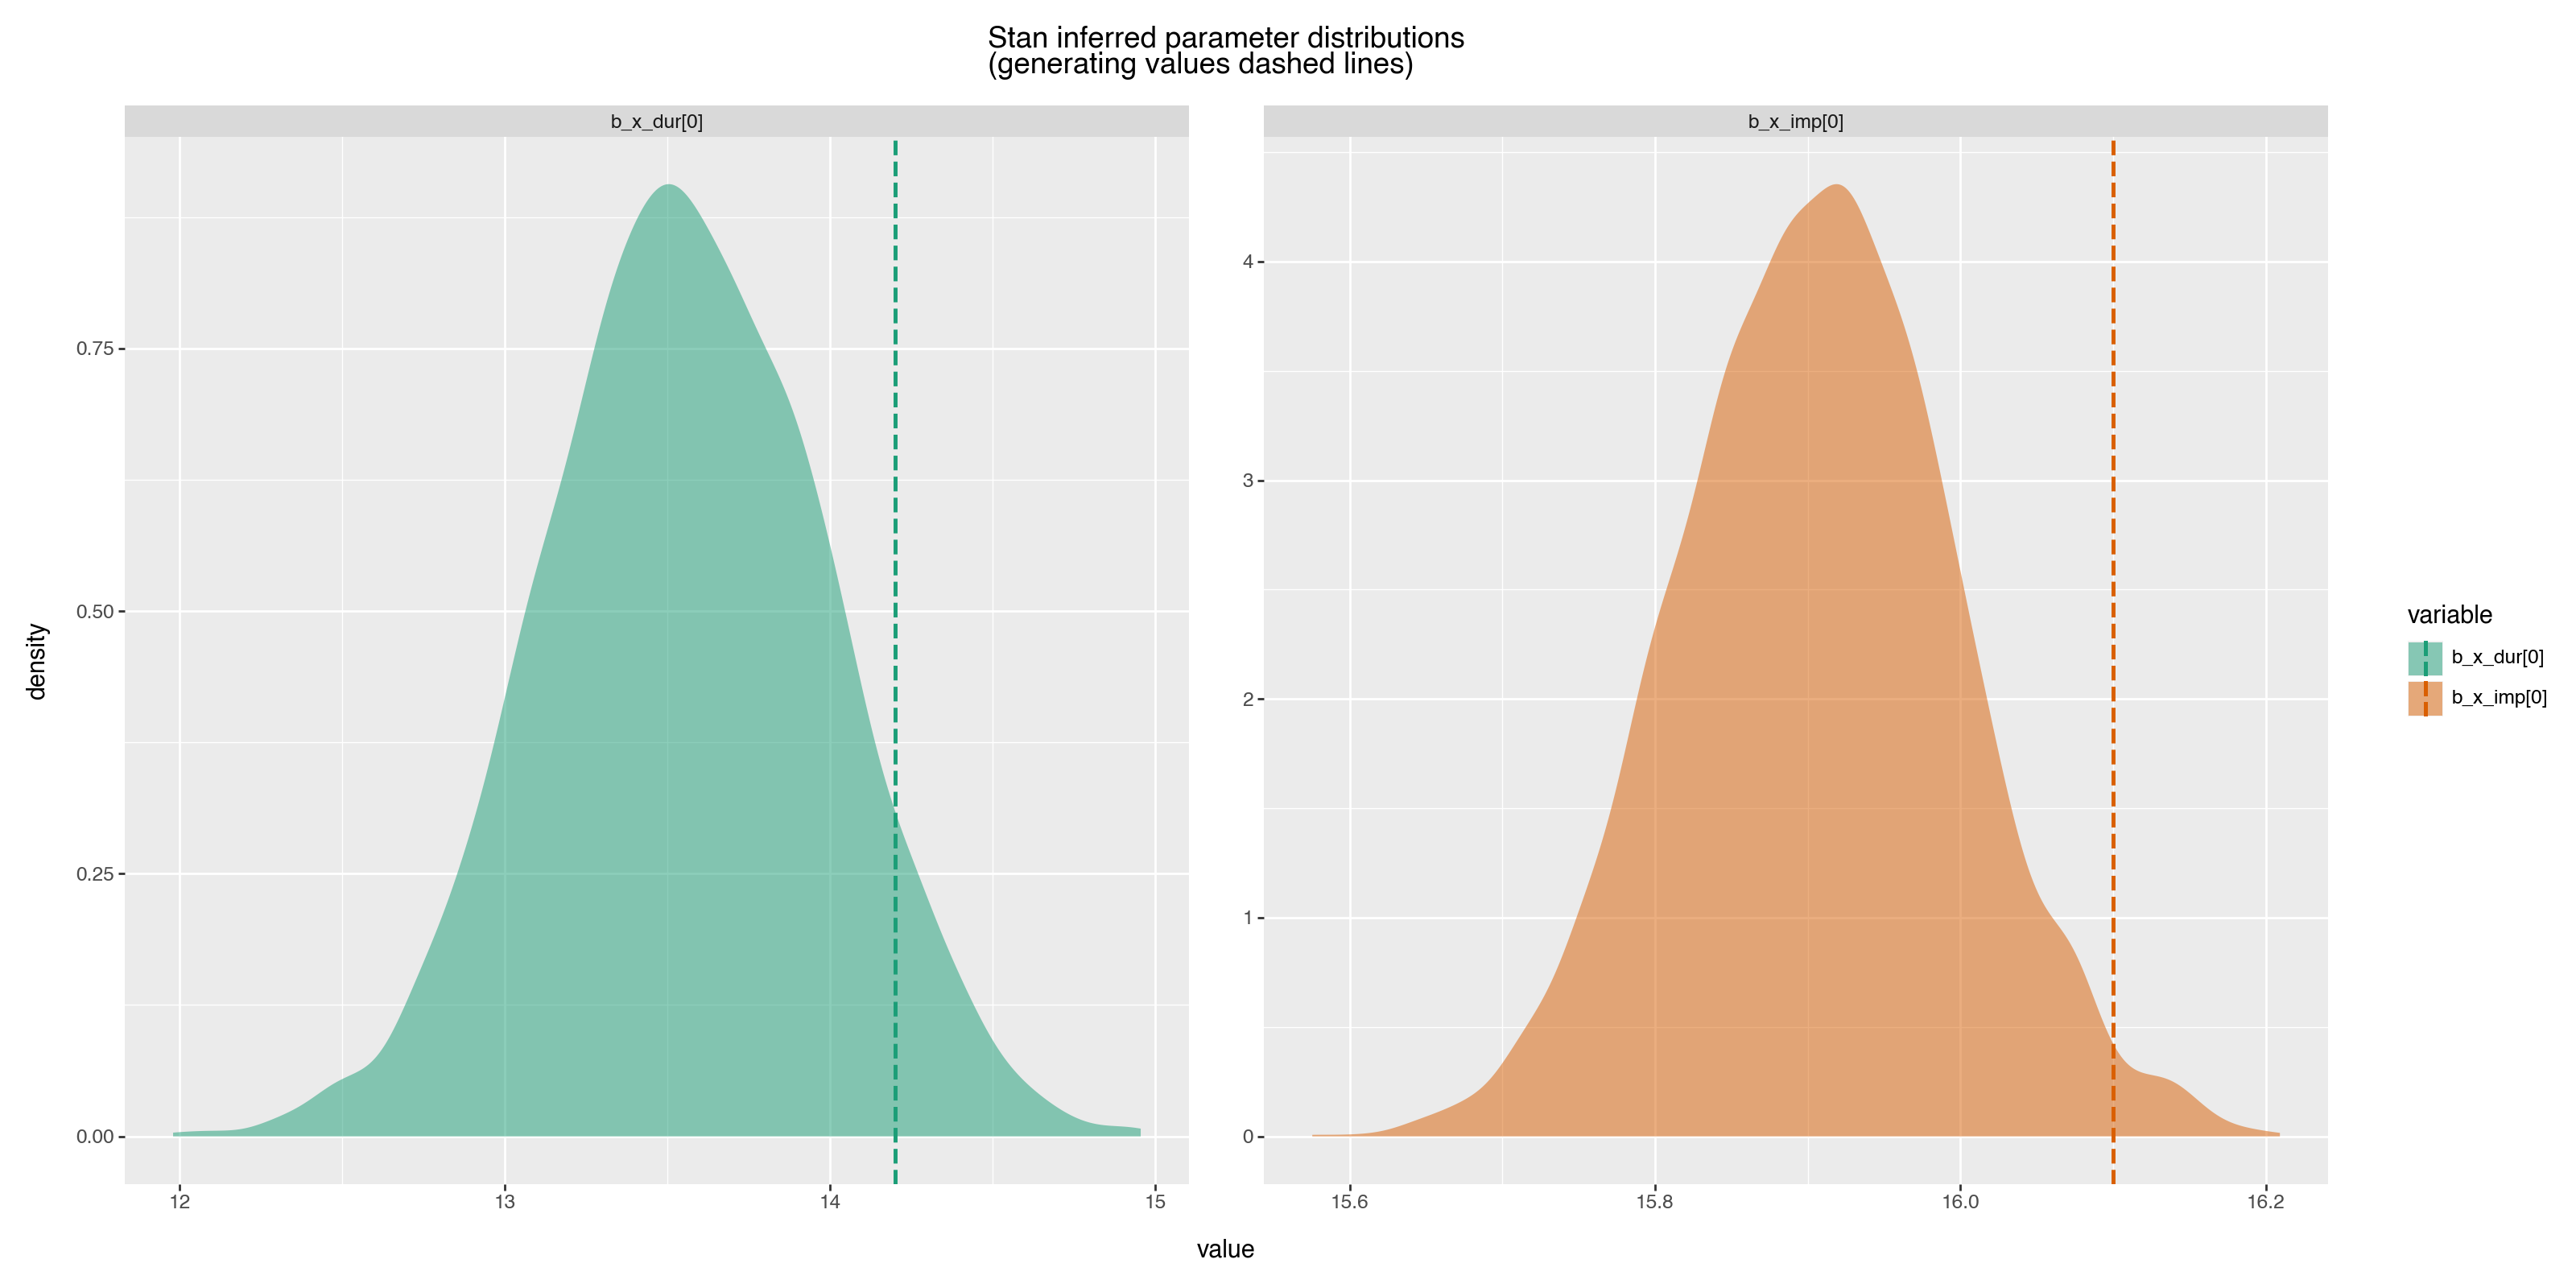

In [9]:
answer_frame = pd.DataFrame(
    {
        "b_x_dur[0]": [generating_params["b_z"][0]],
        "b_x_imp[0]": [generating_params["b_x"][0]],
    }
)
parameter_plt_frame = forecast_soln_i.loc[:, [c for c in answer_frame.columns]].melt()
(
    ggplot()
    + geom_density(
        data=parameter_plt_frame,
        mapping=aes(x="value", fill="variable", color="variable"),
        linetype="",
        alpha=0.5,
    )
    + geom_vline(
        data=answer_frame.melt(),
        mapping=aes(xintercept="value", color="variable", fill="variable"),
        linetype="dashed",
        size=1,
    )
    + facet_wrap("variable", scales="free")
    + scale_color_brewer(type="qualitative", palette="Dark2")
    + scale_fill_brewer(type="qualitative", palette="Dark2")
    + ggtitle("Stan inferred parameter distributions\n(generating values dashed lines)")
)

And we can plot both the forecasts, and *estimated* quantile bands around the estimated forecasts.


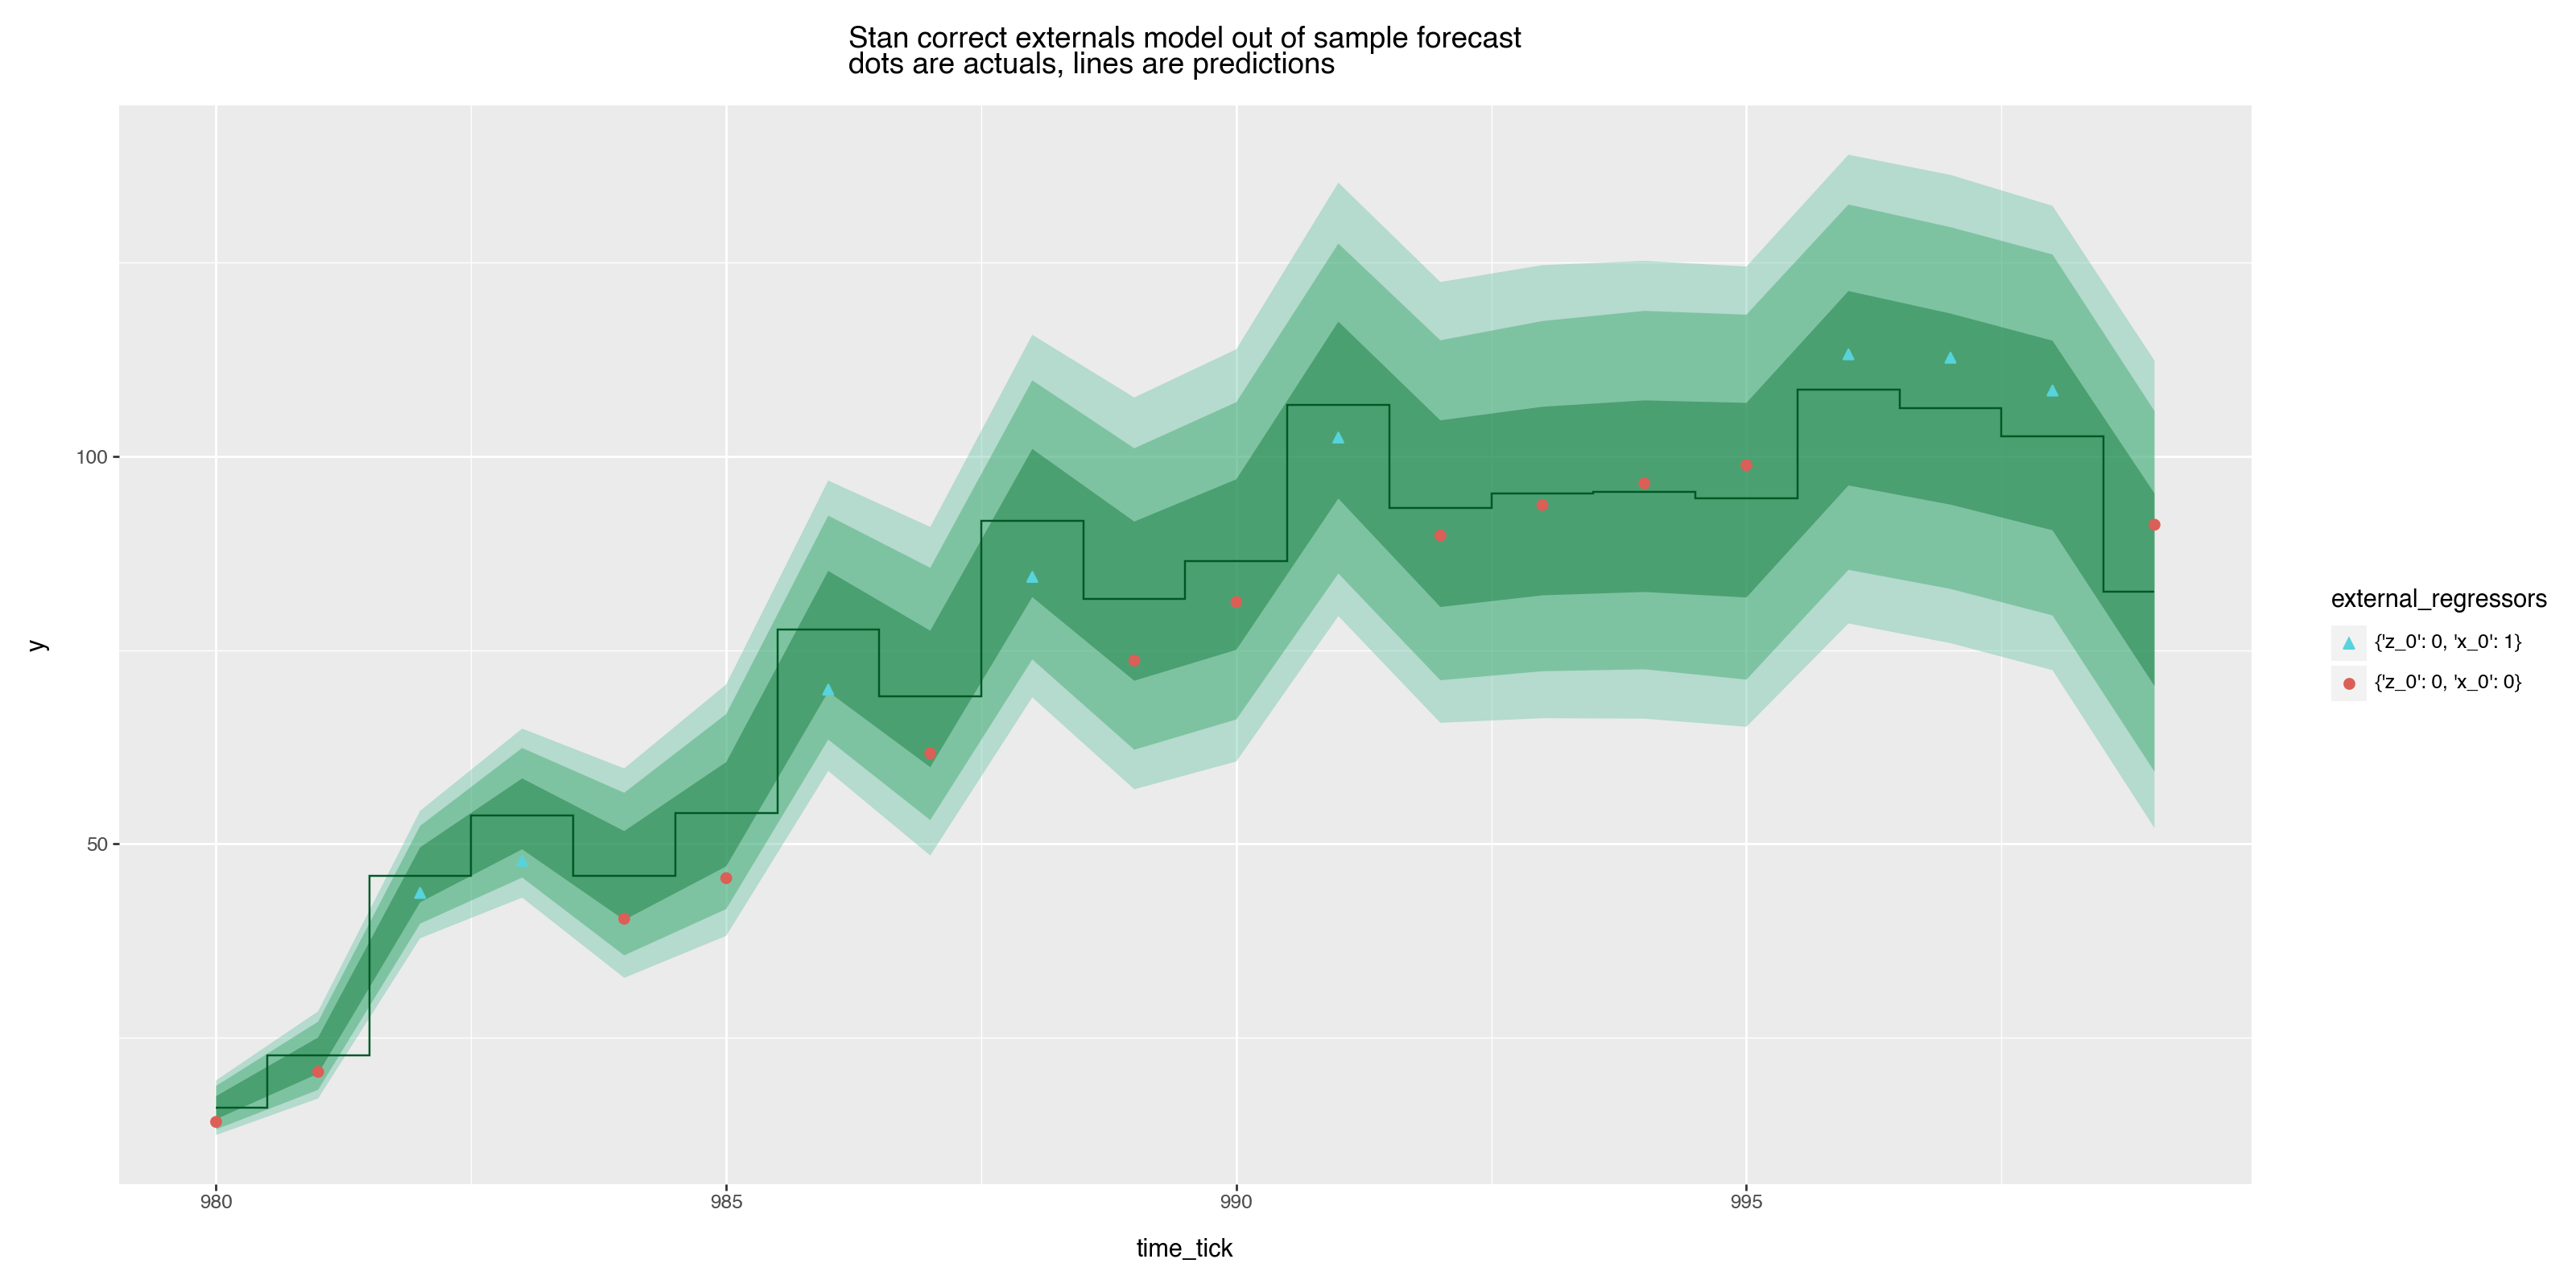

In [10]:
# plot inference over time
plt_i, s_frame_i = plot_forecast(
    forecast_soln_i,
    d_test,
    model_name="Stan correct externals model",
    external_regressors=["z_0", "x_0"],
)
plt_i.show()

In [11]:
forecast_soln_i

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,b_auto_0,b_auto[0],b_auto[1],...,y[990],y[991],y[992],y[993],y[994],y[995],y[996],y[997],y[998],y[999]
0,2422.06,0.966003,0.012435,9.0,511.0,0.0,-1940.36,1.51898,1.93560,-0.963077,...,66.6320,81.7590,68.0079,68.7424,69.5934,71.0835,86.1782,83.6870,79.9718,57.3583
1,2408.97,0.979260,0.012435,9.0,511.0,0.0,-1917.68,1.48301,1.93370,-0.960648,...,64.3027,81.6178,67.4716,67.7043,66.2853,66.4040,80.7445,77.4683,77.5189,60.5005
2,2406.41,0.985678,0.012435,9.0,511.0,0.0,-1921.21,1.56821,1.93958,-0.967600,...,62.7144,87.5645,79.8141,87.2647,90.0175,94.8252,113.3220,117.3030,122.6950,104.7030
3,2394.28,0.780995,0.012435,9.0,511.0,0.0,-1876.91,1.55317,1.93763,-0.964870,...,67.6983,88.3019,74.4680,75.0257,73.9687,72.9321,84.6862,79.7102,77.6661,58.2702
4,2380.00,0.966760,0.012435,9.0,511.0,0.0,-1874.33,1.53446,1.93014,-0.958076,...,70.2634,89.8686,74.8370,76.3530,78.2148,80.2669,92.9408,88.5373,88.1798,71.0078
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,2364.67,0.829765,0.014792,9.0,511.0,0.0,-1896.77,1.47315,1.94180,-0.968659,...,84.7791,105.1100,93.0849,93.2580,94.0806,94.9891,108.7570,109.5600,106.5080,89.4674
3996,2380.05,0.917991,0.014792,9.0,511.0,0.0,-1845.67,1.61915,1.93131,-0.960186,...,105.1580,126.3660,115.2770,120.7540,123.1020,124.3980,139.1080,140.0210,132.9120,111.0100
3997,2403.73,0.909507,0.014792,9.0,511.0,0.0,-1867.24,1.51113,1.94244,-0.969442,...,108.2820,124.7110,107.6520,105.8600,103.6010,100.3070,114.4380,111.4990,107.3590,88.2563
3998,2385.19,0.770991,0.014792,9.0,511.0,0.0,-1882.53,1.61643,1.93609,-0.964987,...,97.9794,118.4330,105.8290,105.6310,106.2460,103.8980,116.5320,111.4680,107.7050,85.2146


In [12]:
plotting_quantiles = [0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]
plotting_colors = {
    "0.05": "#66c2a4",
    "0.1": "#2ca25f",
    "0.25": "#006d2c",
    "0.5": "#005824",
    "0.75": "#006d2c",
    "0.9": "#2ca25f",
    "0.95": "#66c2a4",
}
ribbon_pairs = [("0.05", "0.95"), ("0.1", "0.9"), ("0.25", "0.75")]
sf_frame = forecast_soln_i.loc[
    :, [c.startswith("y[") for c in forecast_soln_i.columns]
].reset_index(drop=True, inplace=False)
sf_frame["trajectory_id"] = range(sf_frame.shape[0])
sf_frame = sf_frame.melt(
    id_vars=["trajectory_id"], var_name="time_tick", value_name="y"
)
sf_frame["time_tick"] = [
    int(c.replace("y[", "").replace("]", "")) for c in sf_frame["time_tick"]
]
sf_frame = (
    sf_frame.loc[:, ["time_tick", "y"]]
    .groupby(["time_tick"])
    .quantile(plotting_quantiles)
    .reset_index(drop=False)
)
sf_frame.rename(columns={"level_1": "quantile"}, inplace=True)
sf_frame["quantile"] = [str(v) for v in sf_frame["quantile"]]
sf_p = sf_frame.pivot(index="time_tick", columns="quantile")
sf_p.columns = [c[1] for c in sf_p.columns]
sf_p = sf_p.reset_index(drop=False, inplace=False)

/opt/anaconda3/envs/prob_env/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 900 rows containing missing values.
/opt/anaconda3/envs/prob_env/lib/python3.11/site-packages/plotnine/geoms/geom_path.py:100: PlotnineWarning: geom_path: Removed 900 rows containing missing values.


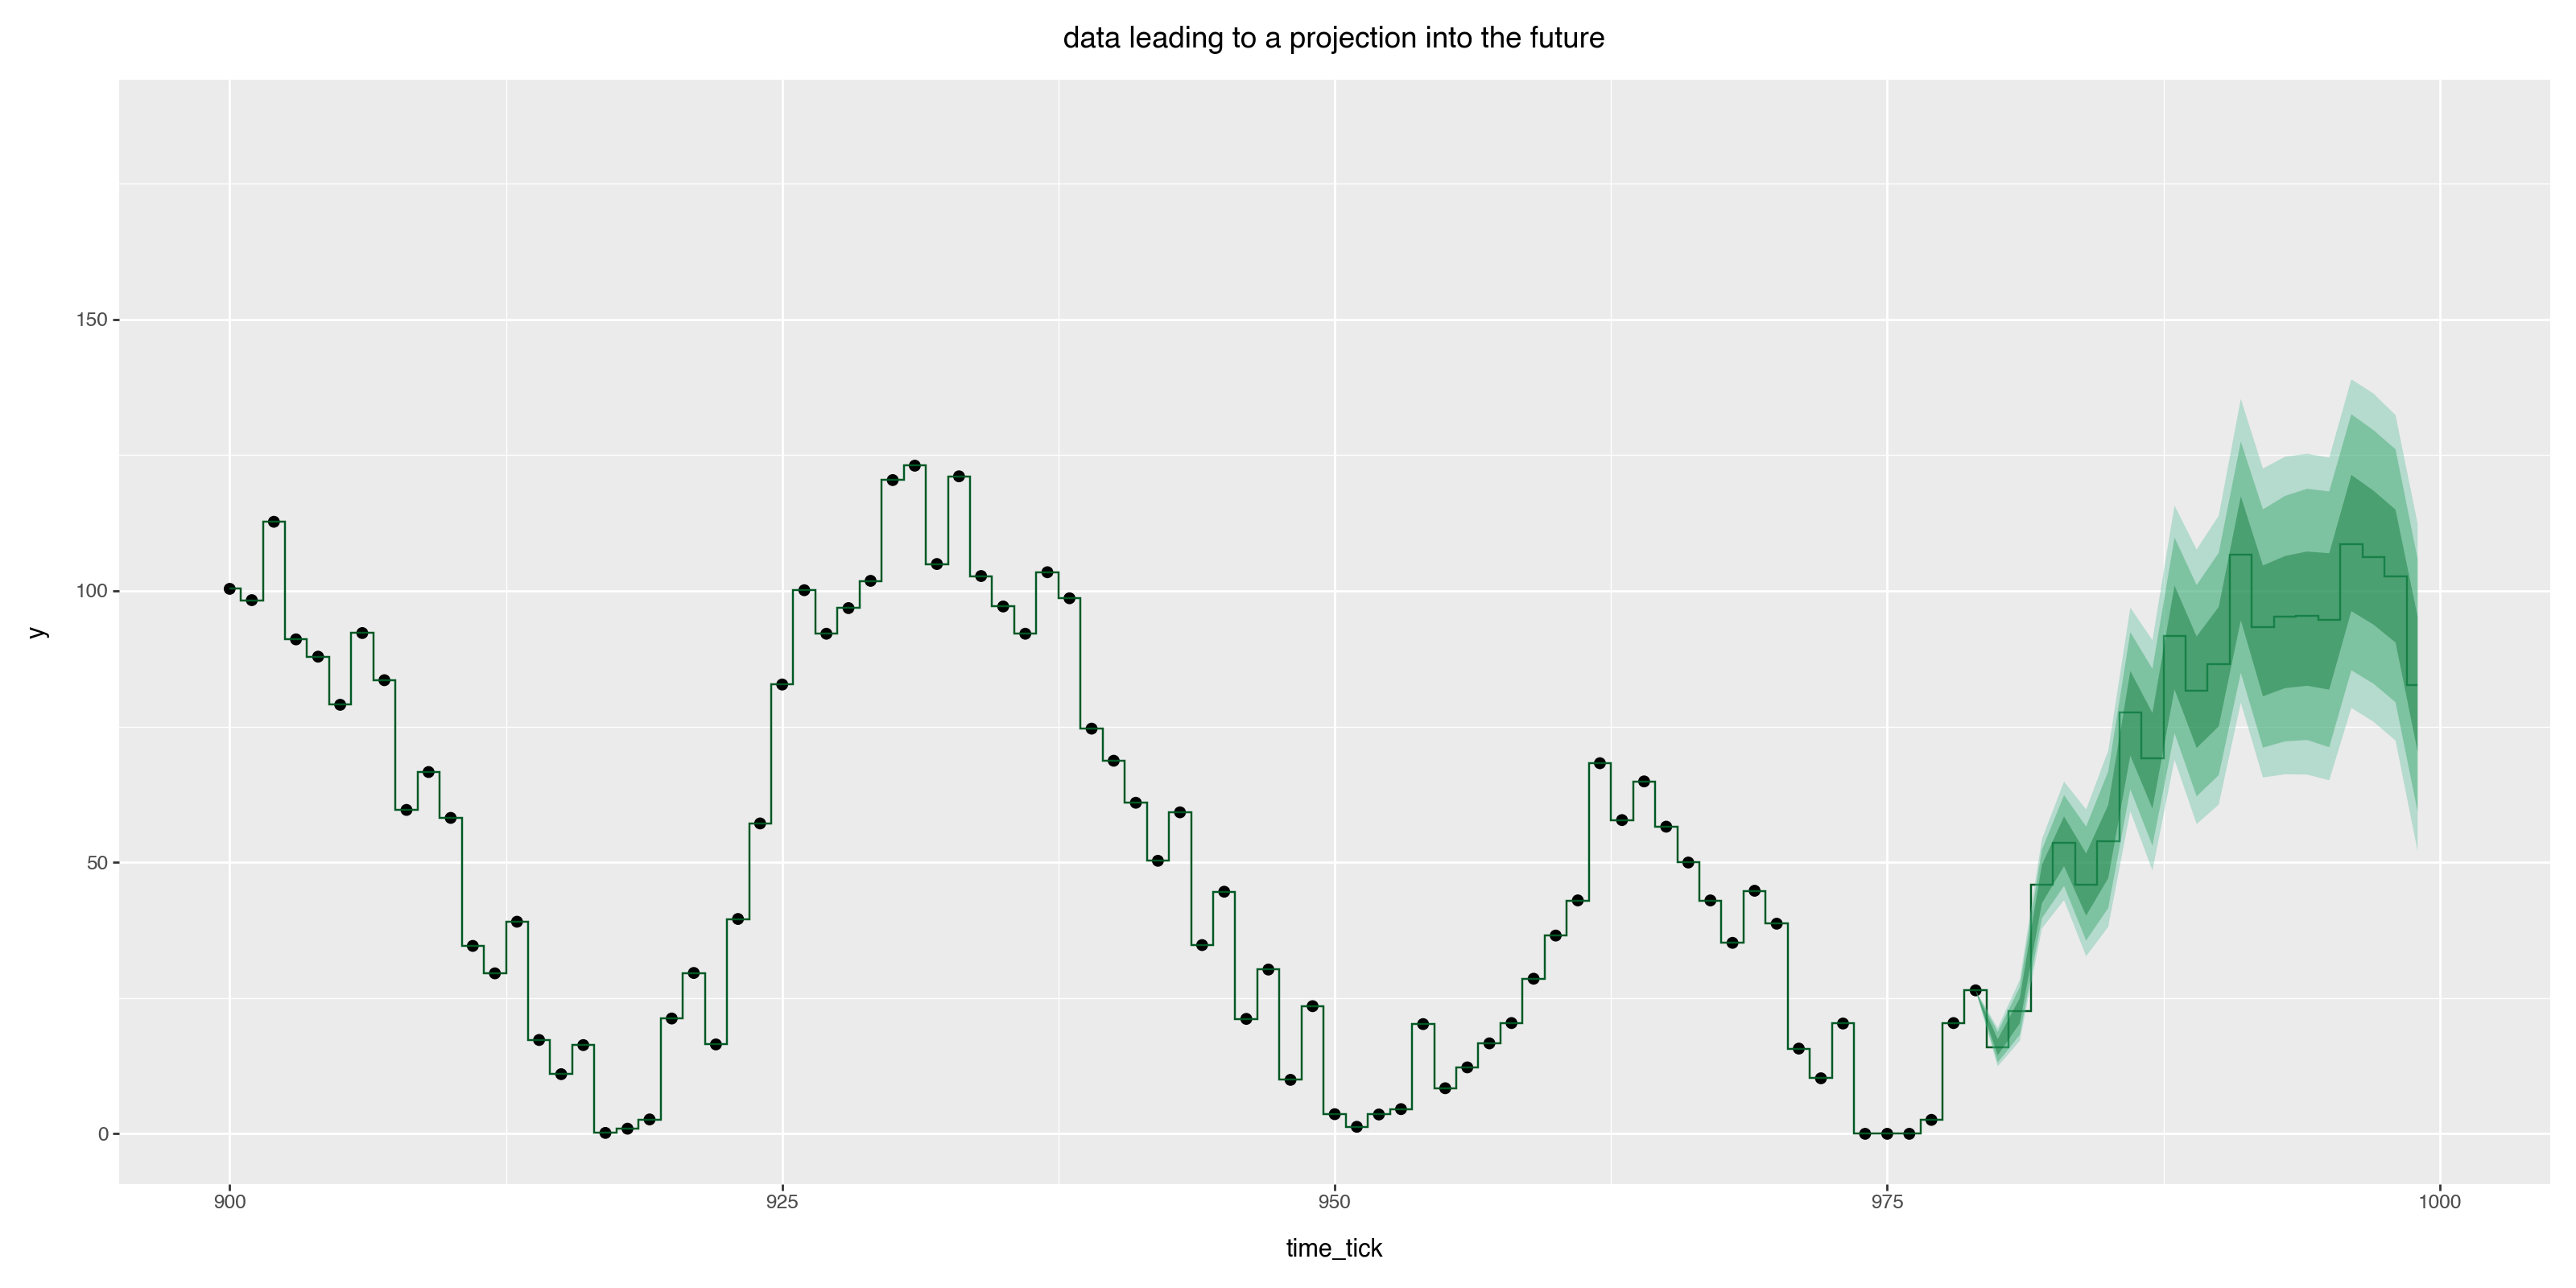

In [13]:
plt = ggplot()
plt = (
    plt
    + geom_point(
        data=d_train,
        mapping=aes(x="time_tick", y="y"),
        size=2,
    )
    + geom_step(
        data=sf_frame.loc[sf_frame["quantile"] == "0.5", :],
        mapping=aes(x="time_tick", y="y"),
        direction="mid",
        color="#005824",
    )
)
for r_min, r_max in ribbon_pairs:
    plt = plt + geom_ribbon(
        data=sf_p,
        mapping=aes(x="time_tick", ymin=r_min, ymax=r_max),
        fill=plotting_colors[r_min],
        alpha=0.4,
        linetype="",
    )
plt = plt + xlim(900, 1000) + ggtitle("data leading to a projection into the future")
plt

/opt/anaconda3/envs/prob_env/lib/python3.11/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 900 rows containing missing values.
/opt/anaconda3/envs/prob_env/lib/python3.11/site-packages/plotnine/geoms/geom_path.py:100: PlotnineWarning: geom_path: Removed 900 rows containing missing values.


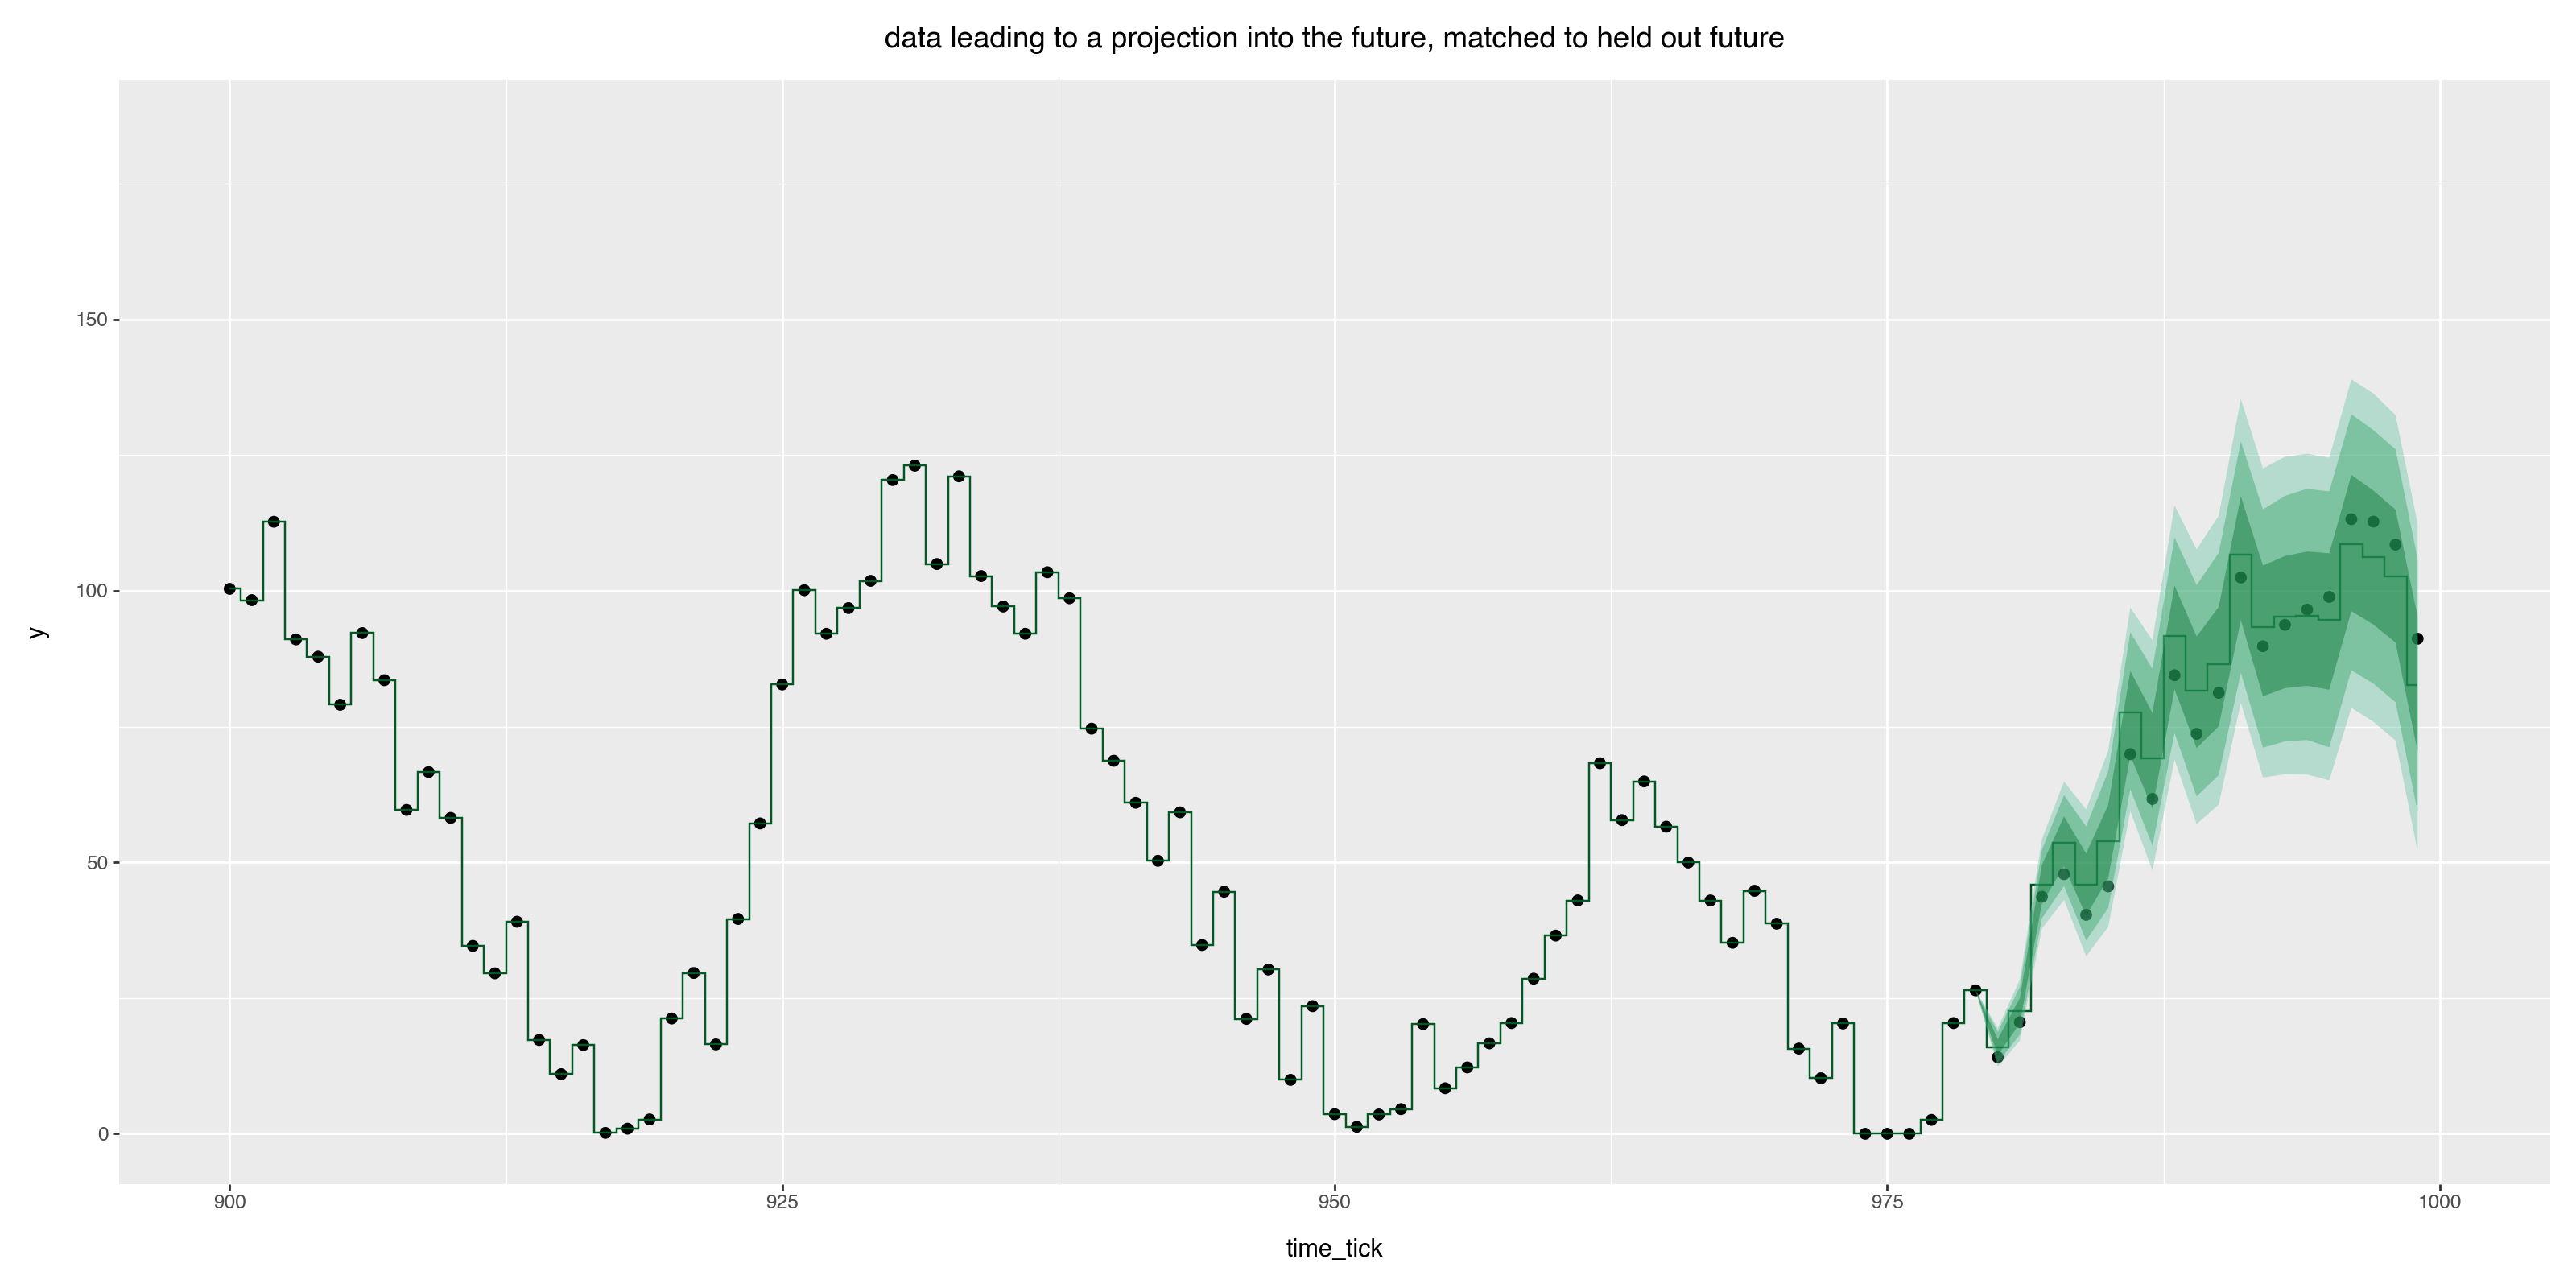

In [14]:
plt = ggplot()
plt = (
    plt
    + geom_point(
        data=d_test,
        mapping=aes(x="time_tick", y="y"),
        size=2,
    )
    + geom_point(
        data=d_train,
        mapping=aes(x="time_tick", y="y"),
        size=2,
    )
    + geom_step(
        data=sf_frame.loc[sf_frame["quantile"] == "0.5", :],
        mapping=aes(x="time_tick", y="y"),
        direction="mid",
        color="#005824",
    )
)
for r_min, r_max in ribbon_pairs:
    plt = plt + geom_ribbon(
        data=sf_p,
        mapping=aes(x="time_tick", ymin=r_min, ymax=r_max),
        fill=plotting_colors[r_min],
        alpha=0.4,
        linetype="",
    )
plt = (
    plt
    + xlim(900, 1000)
    + ggtitle(
        "data leading to a projection into the future, matched to held out future"
    )
)
plt

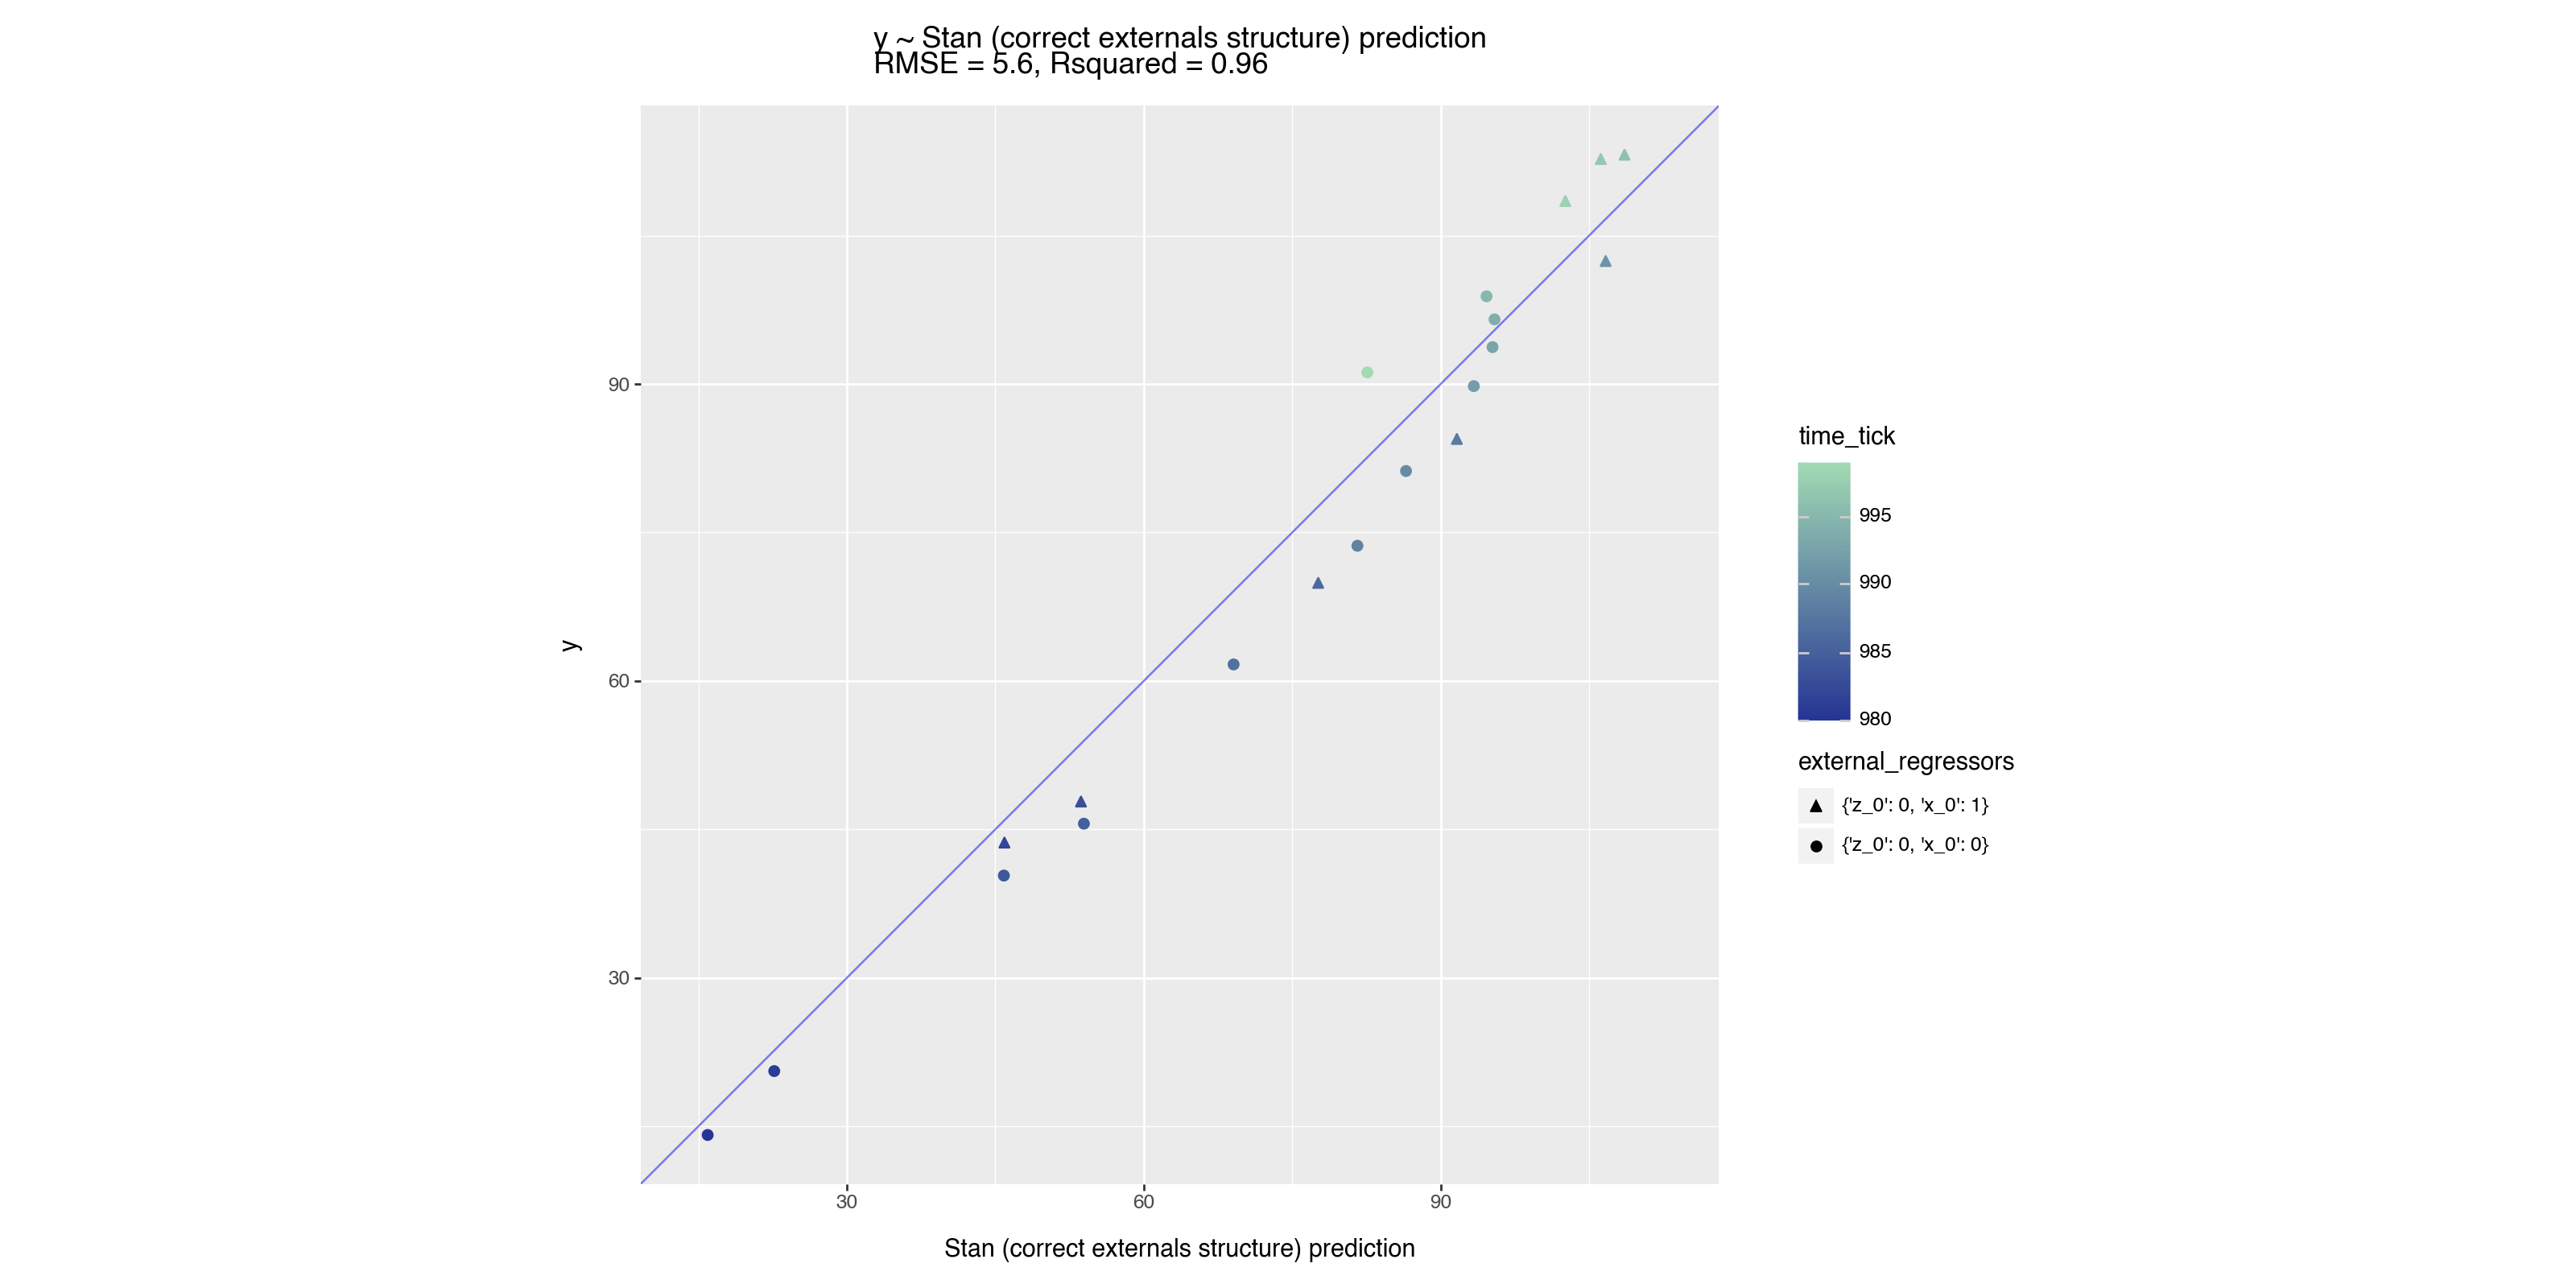

In [15]:
# plot quality of fit as a scatter plot
d_test["Stan (correct externals structure) prediction"] = extract_sframe_result(
    s_frame_i
)
plot_model_quality(
    d_test=d_test,
    result_name="Stan (correct externals structure) prediction",
    external_regressors=["z_0", "x_0"],
)

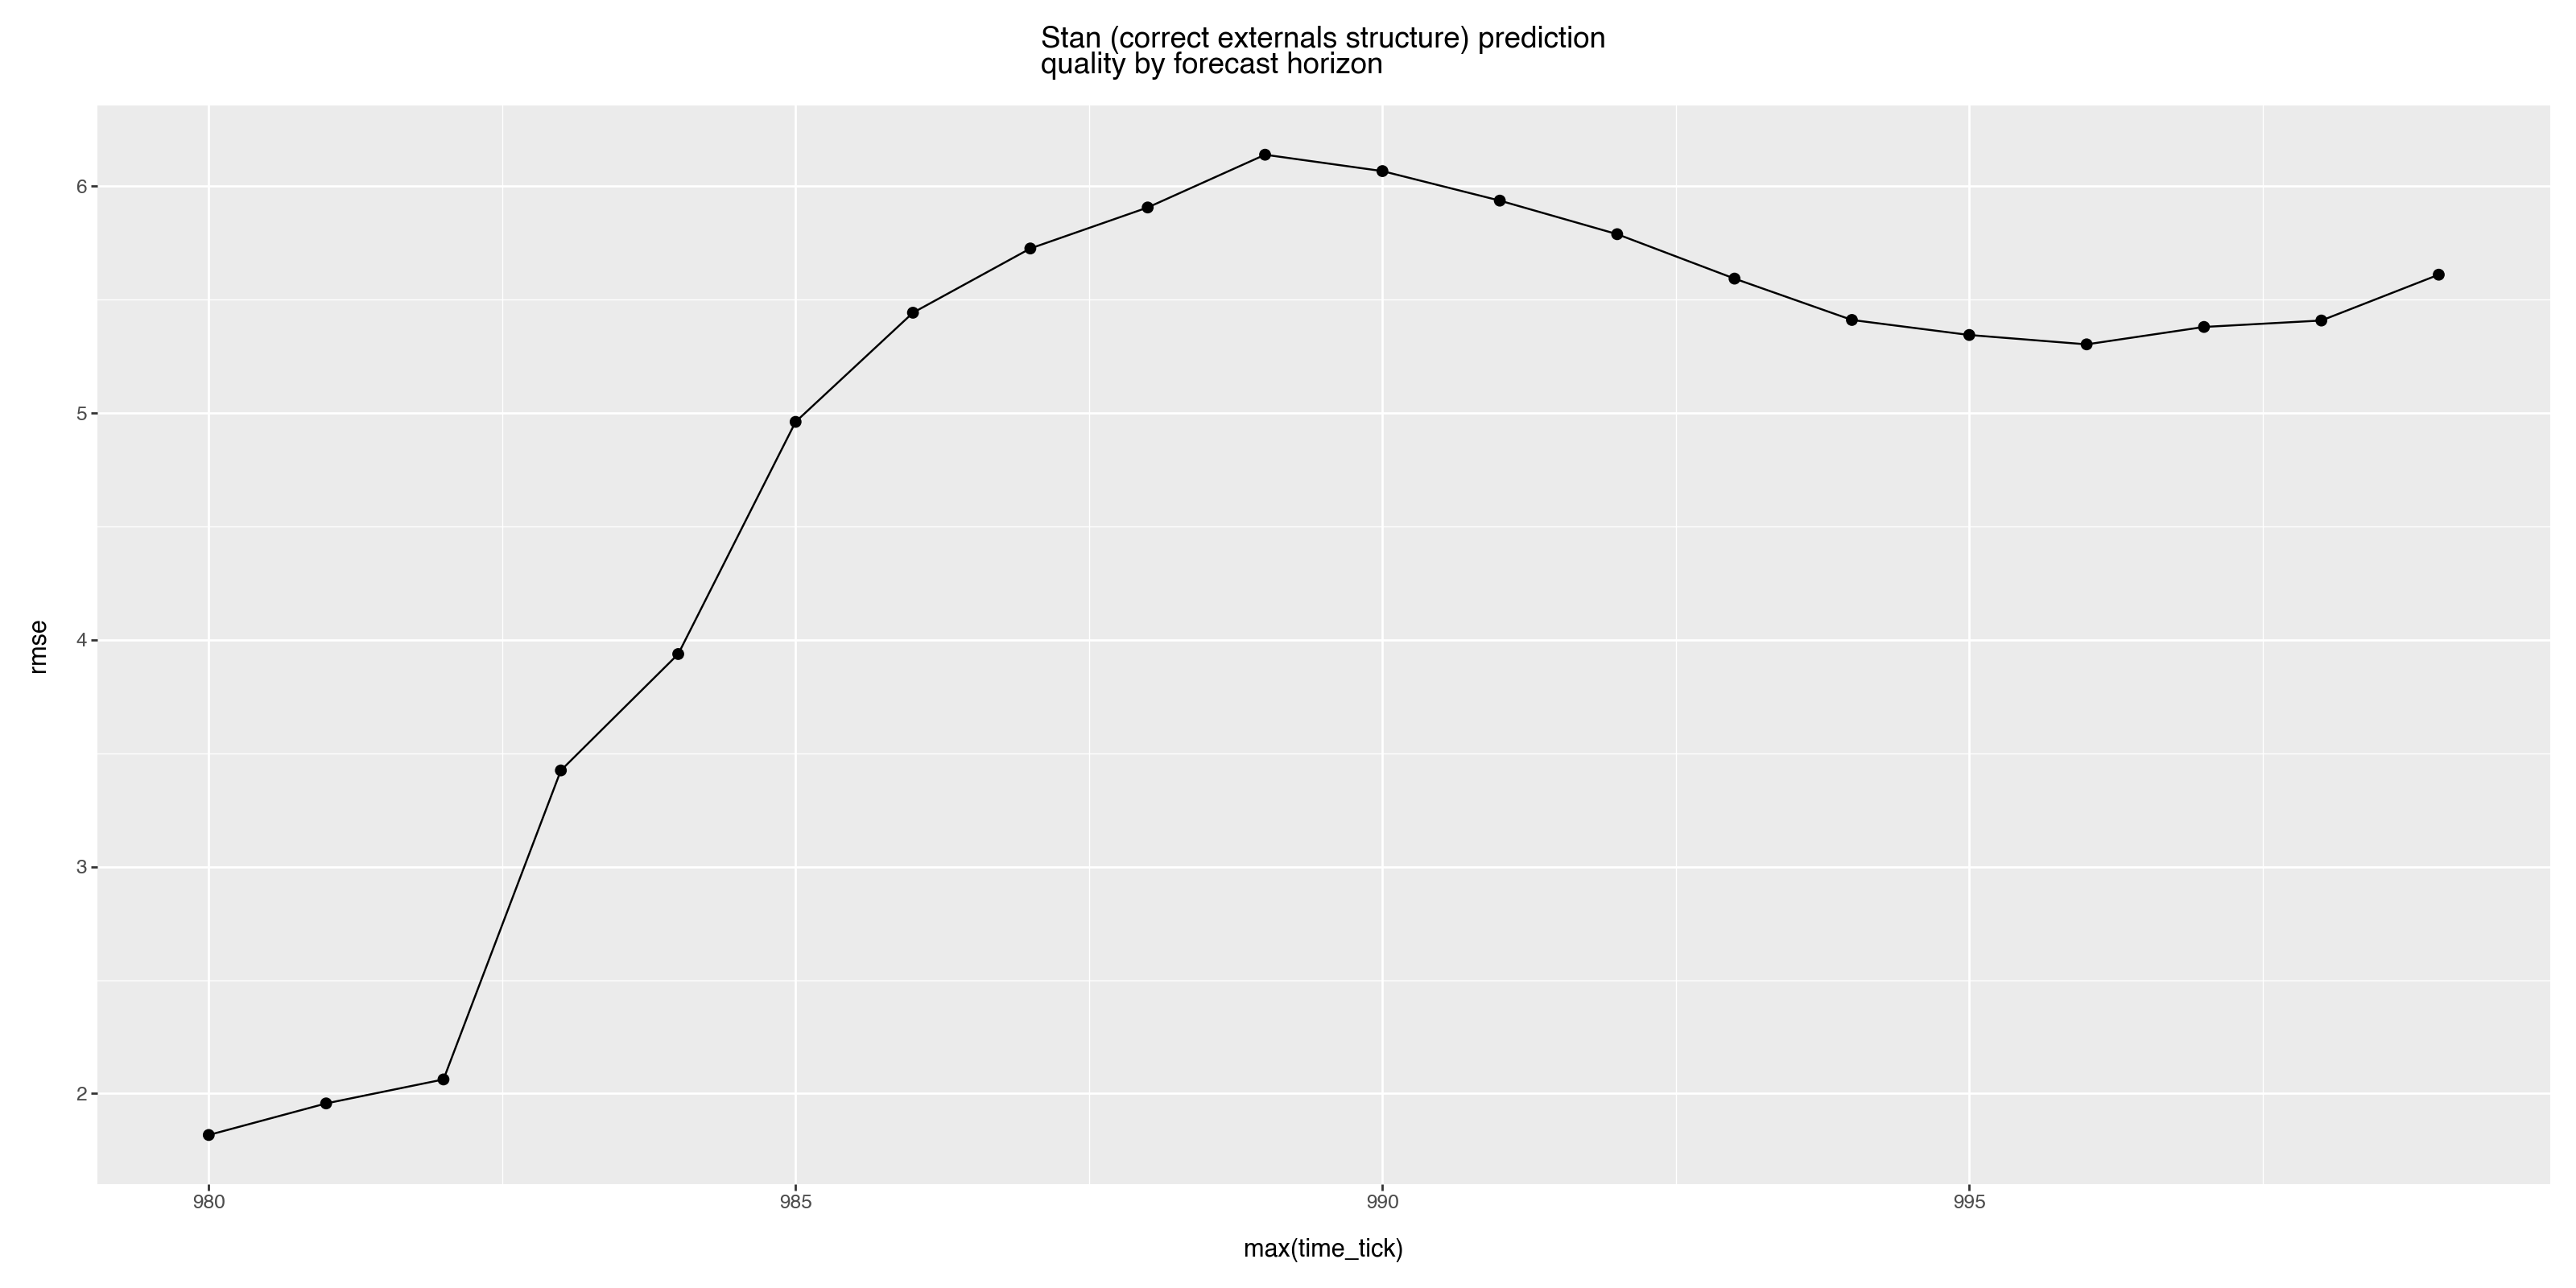

In [16]:
# plot quality as a function of how far out we are predicting
plot_model_quality_by_prefix(
    s_frame=s_frame_i,
    d_test=d_test,
    result_name="Stan (correct externals structure) prediction",
)

The model identifies 3 very valuable things:

  * Estimates of the model parameters: 
     * `b_auto_0`
     * `b_auto[0]`
     * `b_auto[1]`
     * `b_x_dur[0]`
     * `b_x_imp[0]`
  * Projections or applications of the model for future `time_tick`s 950 through 999.
  * Good inferences of the most recent unobserved states `y_auto[948]` and `y_auto[949]` in the training period.

The third item provides a much more useful estimate of then hidden state (based on evaluation of trajectories through the entire training period) than the simple single point estimate `y_auto[i] ~ y[i] * b_x_impl[0] - x_0[i]`. One can evolve estimates forward from these inferences, and that is not always the case for the simple expected value estimates.

The issue with the simple (or naive) estimates being: they are single value point estimates, not necessarily compatible with *any* of the estimate sampling trajectories. Plugging in the naive estimates often does not allow one to evolve the prediction trajectories forward in a sensible manner. The detailed estimates from the Stan sampler do allow such forward evolution of estimates (either inside the Stan sampler as shown, or as a simple external procedure).


For this model the future state is determined by the model parameters plus the last hidden state estimated int the training period. The distribution of these estimates across different samples is shown here. 


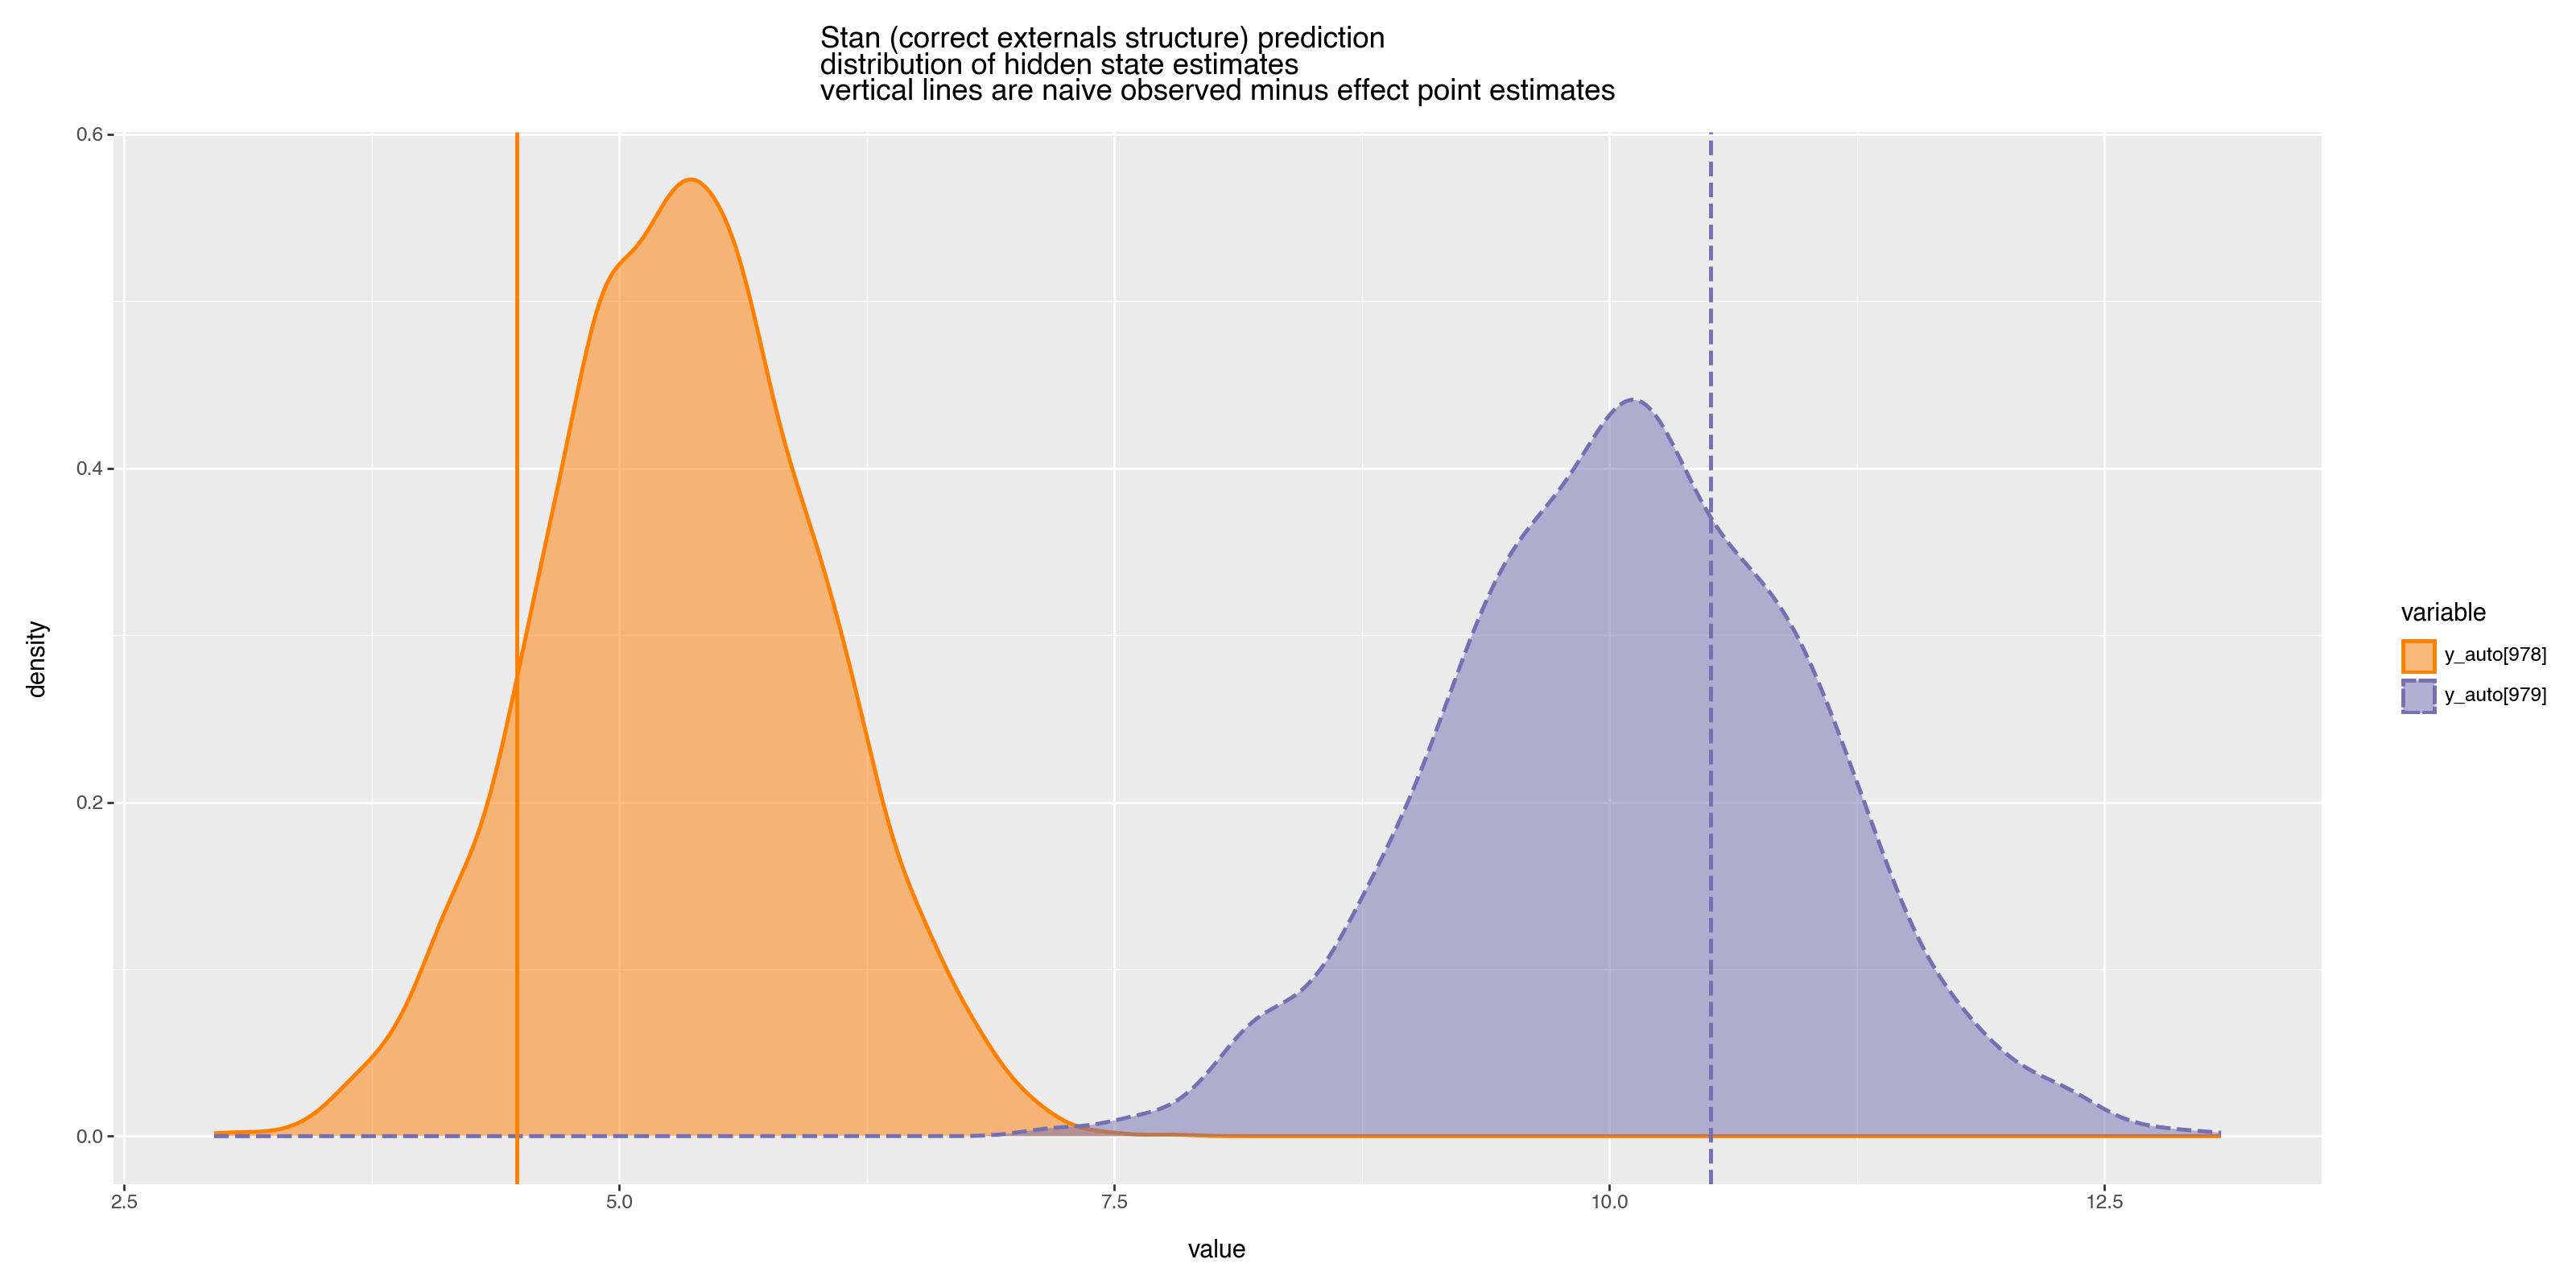

In [17]:
plot_recent_state_distribution(
    d_train=d_train,
    forecast_soln=forecast_soln_i,
    generating_lags=modeling_lags,
    result_name="Stan (correct externals structure) prediction",
)

## Bayesian method without external regressors


Let's get back to overall methodology.

As a lower-bound on model quality we can try a Bayesian (Stan) model without external regressors.


In [18]:
# define a Stan model without external predictors
stan_model_with_forecast_0, stan_model_with_forecast_src_0 = (
    define_Stan_model_with_forecast_period(
        application_lags=modeling_lags,
        n_transient_external_regressors=0,
        n_durable_external_regressors=0,
    )
)

In [19]:
# show the model specification
print(stan_model_with_forecast_src_0)


data {
  int<lower=1> N_y_observed;                  // number of observed y outcomes
  int<lower=1> N_y_future;                    // number of future outcomes to infer
  vector<lower=0>[N_y_observed] y_observed;            // observed outcomes
}
parameters {
  real b_auto_0;                      // auto-regress intercept
  vector[2] b_auto;                           // auto-regress coefficients
  vector<lower=0>[N_y_future] y_future;                // to be inferred future state
  vector<lower=0>[N_y_observed + N_y_future] y_auto;   // unobserved auto-regressive state
  real<lower=0> b_var_y_auto;                 // presumed y_auto (durable) noise variance
  real<lower=0> b_var_y;                      // presumed y (transient) noise variance
}
transformed parameters {
        // y_observed and y_future in one notation (for subscripting)
  vector[N_y_observed + N_y_future] y;        
  y[1:N_y_observed] = y_observed;
  y[(N_y_observed + 1):(N_y_observed + N_y_future)] = y_future;
}
m

In [20]:
# sample from Stan model solutions
forecast_soln_0 = solve_forecast_by_Stan(
    model=stan_model_with_forecast_0,
    d_train=d_train,
    d_apply=d_test,
)

In [21]:
# summarize parameter estimates
forecast_soln_0.loc[:, [c for c in forecast_soln_0 if c.startswith("b_")]].median()

b_auto_0        1.713735
b_auto[0]       1.922960
b_auto[1]      -0.952653
b_var_y_auto    1.996910
b_var_y         7.722555
dtype: float64

In [22]:
# show original generative parameters
generating_params

{'b_auto_0': 1.2804125781056719,
 'b_auto': [1.9753766811902755, -1],
 'b_z': [14.2],
 'b_x': [16.1],
 'generating_lags': [1, 2],
 'modeling_lags': [1, 2]}

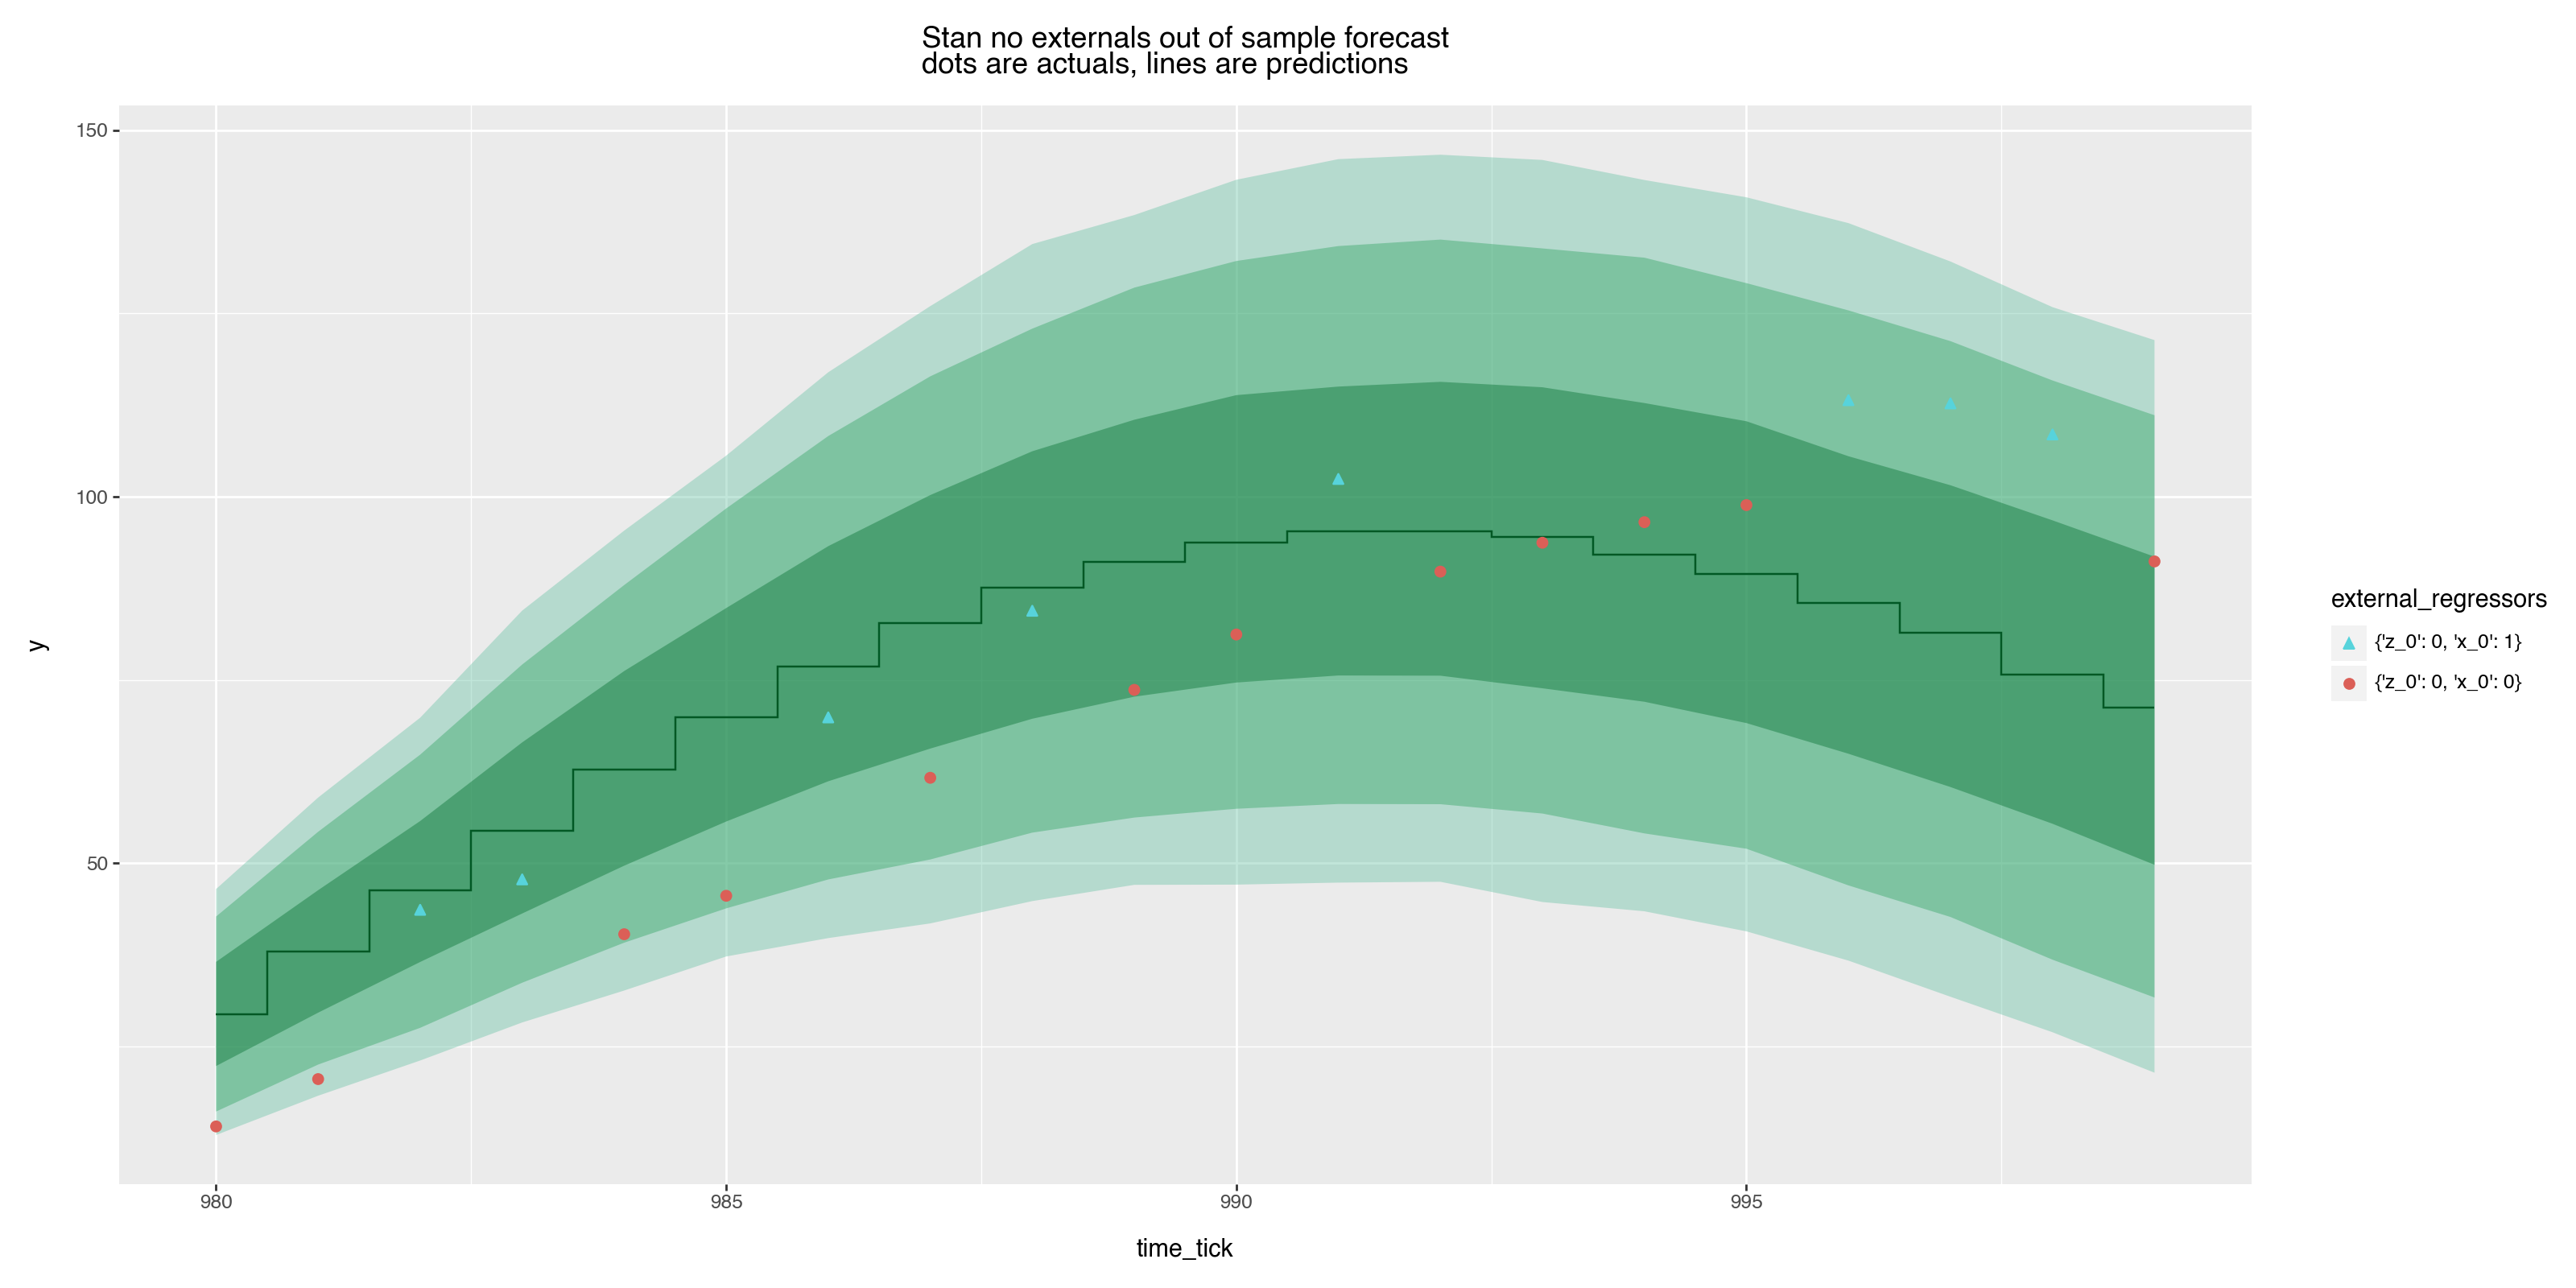

In [23]:
# plot fit over time
plt_0, s_frame_0 = plot_forecast(
    forecast_soln_0,
    d_test,
    model_name="Stan no externals",
    external_regressors=["z_0", "x_0"],
)
plt_0.show()

Notice both the predictions are "middle of the road" estimates again.


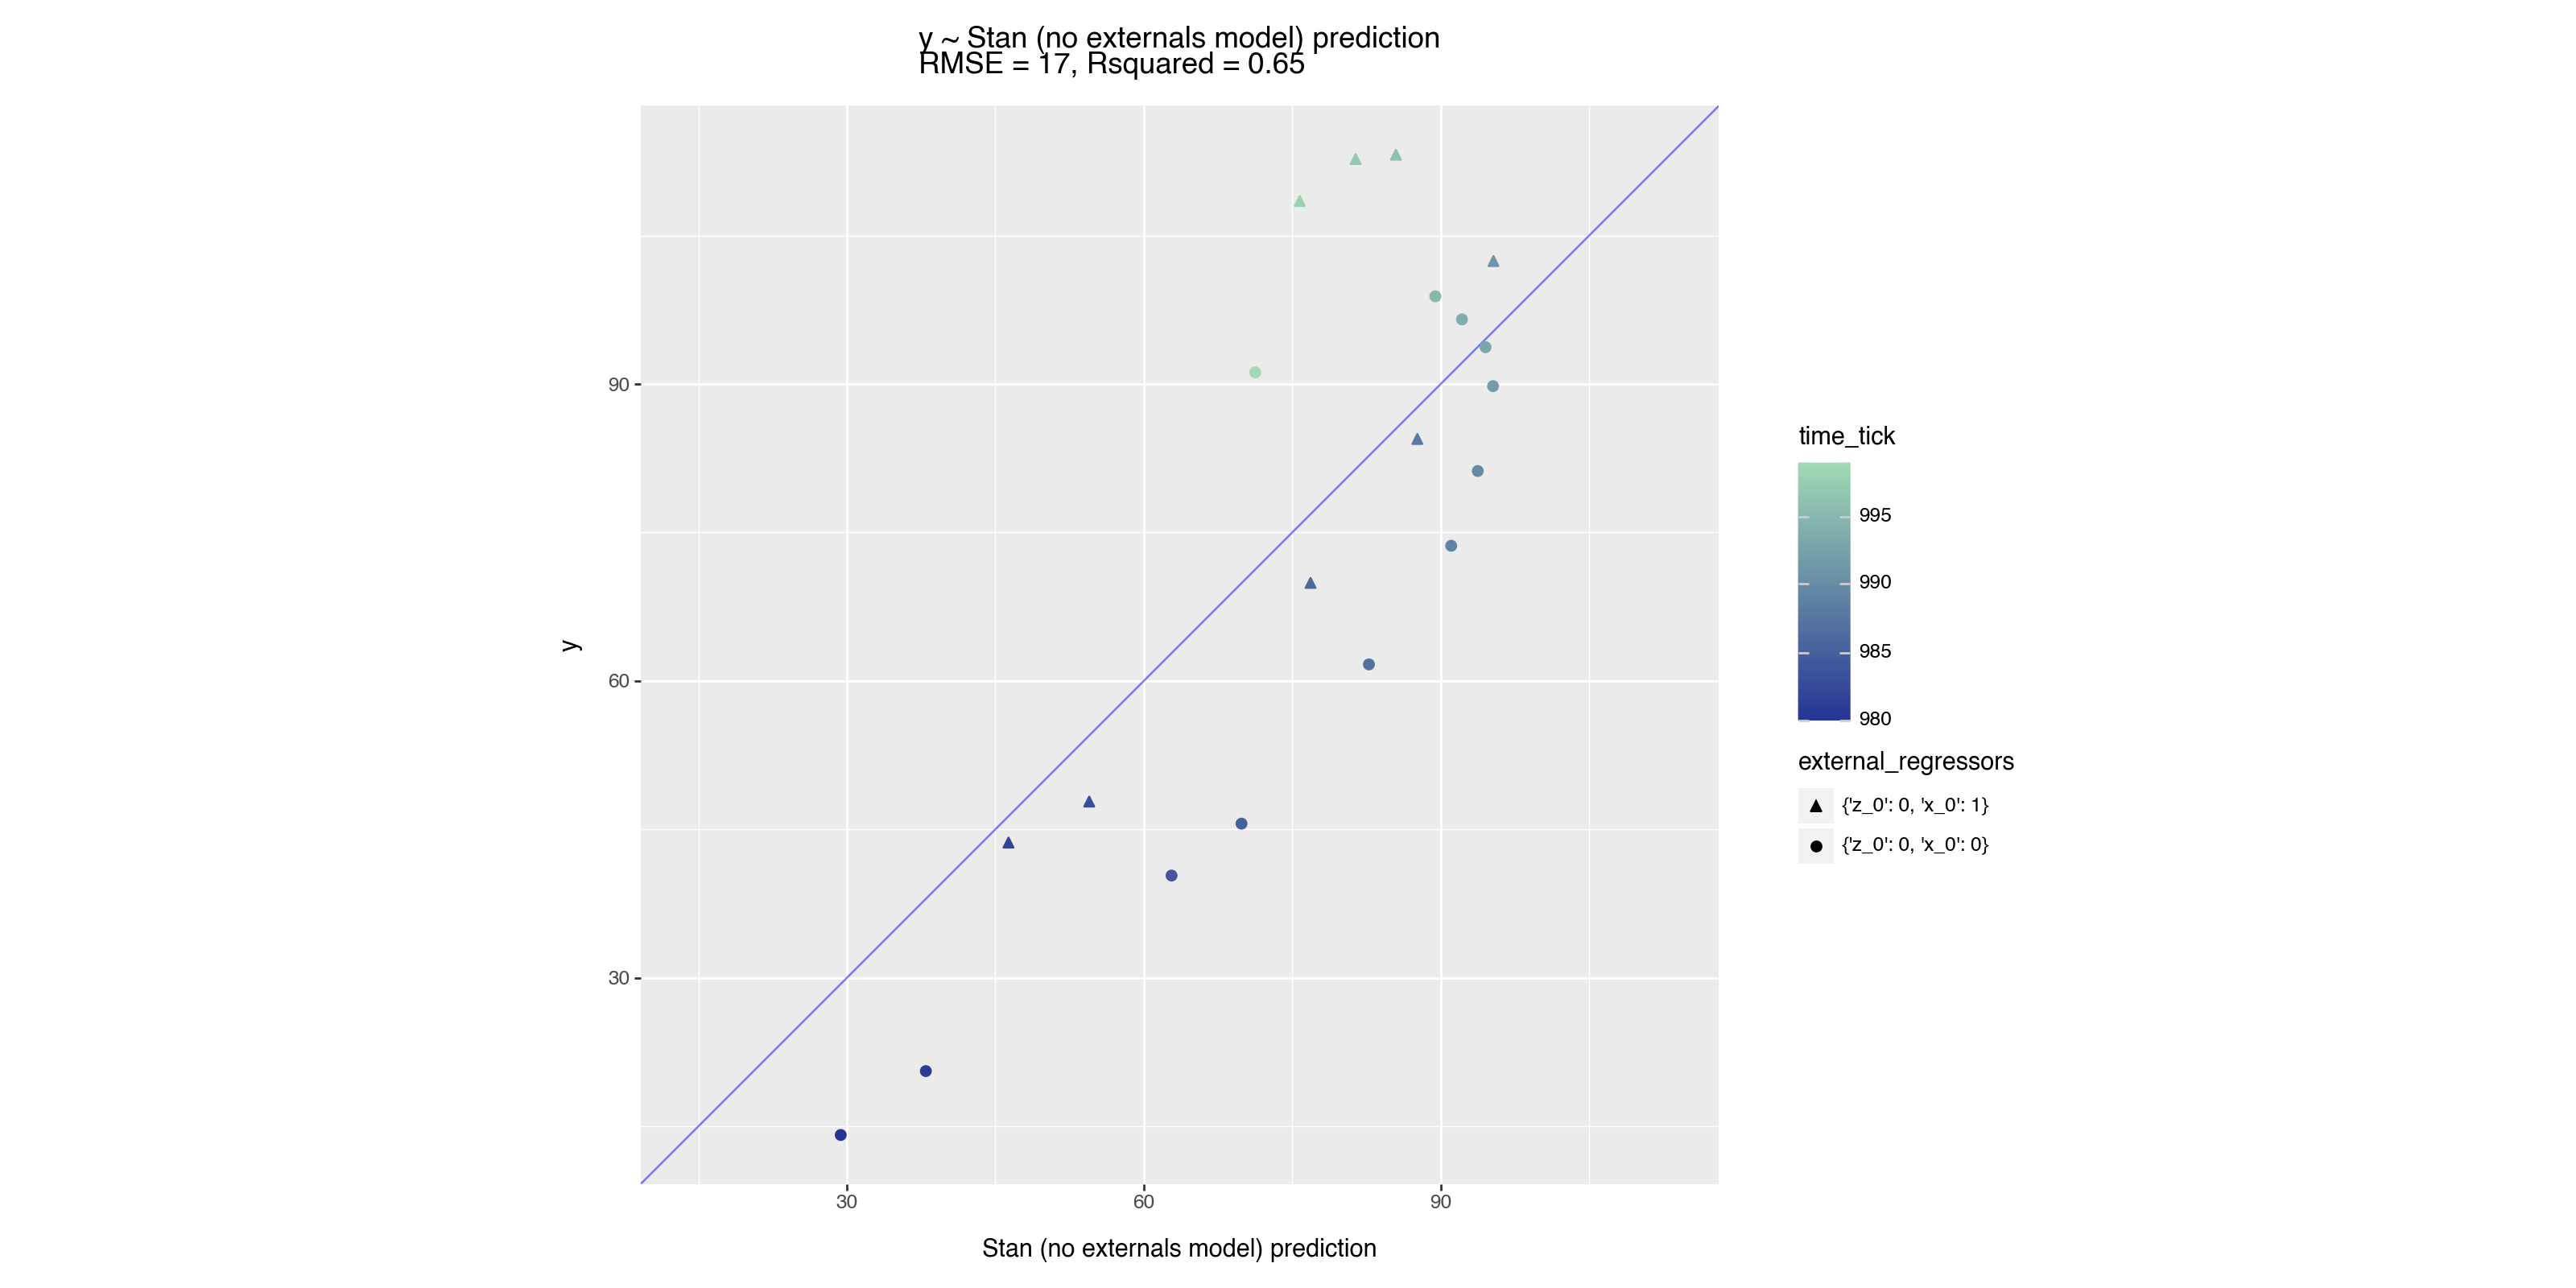

In [24]:
# plot quality of fit as a scatter plot
d_test["Stan (no externals model) prediction"] = extract_sframe_result(s_frame_0)
plot_model_quality(
    d_test=d_test,
    result_name="Stan (no externals model) prediction",
    external_regressors=["z_0", "x_0"],
)

## Conclusion


And that concludes our note on modeling in the presence of external regressors. The main point is: one has to specify the structure of the regressors. Do they cause durable effects (such as marketing efforts) or do they cause transient effects (such as one-off sales events)? Also: we would like such specifications to be in terms familiar to domain experts, and not deep in ARMAX or transfer function terminology.
